In [215]:
%load_ext autoreload
# Set extension to reload modules every time before executing code
%autoreload 2  #0 to turn of reloading

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [216]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [217]:
import bokeh
import time
import copy
import scipy.stats as ss
from scipy.optimize import curve_fit
from coffea import hist, processor, nanoevents, util
from coffea.nanoevents.methods import candidate
from coffea.nanoevents import NanoAODSchema, BaseSchema

import awkward as ak
import numpy as np
import glob as glob
import itertools
import pandas as pd
from numpy.random import RandomState

from dask.distributed import Client
import inspect
import matplotlib.pyplot as plt
import matplotlib as mpl

from pltStyle import pltStyle
import os
# %matplotlib notebook 
# %matplotlib notebook 

### Import processor

In [218]:
from CoffeaJERCProcessor_L5 import Processor

Parameters of the run

In [219]:
UsingDaskExecutor = True
CoffeaCasaEnv     = False
load_preexisting  = True    ### True if don't repeat the processing of files and use preexisting JER from output
test_run          = False     ### True if run only on one file
load_fit_res      = False

fine_etabins      = False


tag = '_L5'

exec('from CoffeaJERCProcessor'+tag+' import Processor') 

add_tag = '_QCD-JME' #'_Herwig-TTBAR' # '_TTBAR' #'_QCD' # '_testing_19UL18' # '' #fine_etaBins
if fine_etabins:
    add_tag='_fine_etaBins'+add_tag
# add_tag='_fine_etaBins'+add_tag
tag_full = tag+add_tag

outname = 'out/CoffeaJERCOutputs'+tag_full+'.coffea'
outname = outname+'_test' if test_run else outname

if load_preexisting == True:
    UsingDaskExecutor = False
    
if not os.path.exists("out"):
    os.mkdir("out")
    
if not os.path.exists("out_txt"):
    os.mkdir("out_txt")
    
if test_run and not os.path.exists("test"):
    os.mkdir("test/")
    os.mkdir("test/out_txt")
    os.mkdir("test/fig")

In [220]:
## assume running on the LPC
xrootdstr = 'root://cmsxrootd.fnal.gov/'
# assume running on the lxplus
# xrootdstr = 'root://cms-xrd-global.cern.ch//'

# if running on coffea casa instead...
if CoffeaCasaEnv:
    xrootdstr = 'root://xcache/'
    
# dataset = 'fileNames/fileNames_QCD20UL18.txt'
# dataset = 'fileNames/fileNames_Herwig_20UL18.txt'
dataset = 'fileNames/fileNames_TTToSemi20UL18.txt'
dataset = 'fileNames/fileNames_QCD20UL18.txt'
dataset = 'fileNames/fileNames_QCD20UL18_JMENano.txt'
dataset = 'fileNames/fileNames_TTToSemi20UL18_JMENano.txt'
# dataset = 'fileNames/fileNames_Herwig_20UL18_JMENano.txt'


rootfiles = open(dataset).read().split()

fileslist = [xrootdstr + file for file in rootfiles]
fileslist = fileslist[:40] # if add_tag=='QCD' else fileslist # :20 to skim the events

/tmp/anpotreb/ipykernel_15595/2861527423.py:19: ResourceWarning: unclosed file <_io.TextIOWrapper name='fileNames/fileNames_TTToSemi20UL18_JMENano.txt' mode='r' encoding='UTF-8'>
  rootfiles = open(dataset).read().split()


In [221]:
# to test on one file, uncomment the line below

fileslist = fileslist
if test_run:
    fileslist = [fileslist[1]]
    ### The smallest file in the RunIISummer20UL18NanoAODv9 dataset
#     fileslist = ['root://cms-xrd-global.cern.ch//'+
#                  '/store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000/792B4CD3-A001-F94F-9AAB-D74D532DE610.root']
# fileslist


Test if certificate works opening the file

In [222]:
import os
### RUN THIS CELL ONLY IF YOU ARE USING SWAN 

##### REMEMBER TO MANUALLY COPY THE PROXY TO YOUR CERNBOX FOLDER AND TO MODIFY THE NEXT LINE
os.environ['X509_USER_PROXY'] = '/afs/cern.ch/user/a/anpotreb/k5-ca-proxy.pem'
if os.path.isfile(os.environ['X509_USER_PROXY']):
    print("Found proxy at {}".format(os.environ['X509_USER_PROXY']))
else:
    print("os.environ['X509_USER_PROXY'] ",os.environ['X509_USER_PROXY'])
os.environ['X509_CERT_DIR'] = '/cvmfs/cms.cern.ch/grid/etc/grid-security/certificates'
os.environ['X509_VOMS_DIR'] = '/cvmfs/cms.cern.ch/grid/etc/grid-security/vomsdir'

Found proxy at /afs/cern.ch/user/a/anpotreb/k5-ca-proxy.pem


In [223]:
import uproot

In [224]:
ff = uproot.open(fileslist[0])
ff.keys()
ff.close()

['tag;1',
 'Events;1',
 'LuminosityBlocks;1',
 'Runs;1',
 'MetaData;1',
 'ParameterSets;1']

In [225]:
fileslist[0]

'root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL18NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/40000/141D3DE9-7495-7445-9344-7C65B9B80F33.root'

In [319]:
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

from coffea.jetmet_tools import JetCorrectionUncertainty #FactorizedJetCorrector
from coffea.jetmet_tools import JECStack, CorrectedJetsFactory

from coffea.lookup_tools import extractor

events = NanoEventsFactory.from_root(
#       'root://cmsxrootd.fnal.gov///store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000/2459AA69-40B1-A944-9E65-DAAE7AF07C5A.root',
#     'root://cmsxrootd.fnal.gov///store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000/0230241E-754C-954D-B5D5-C104C1550830.root',
    'root://cmsxrootd.fnal.gov///store/mc/RunIISummer20UL18NanoAODv9/TT_TuneCH3_13TeV-powheg-herwig7/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/260000/AFB5FE74-F6F0-6D45-A94B-FABA27EA44E8.root',
#     'root://cmsxrootd.fnal.gov///store/mc/RunIISummer20UL18NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/120000/87DEE912-70CF-A549-B10B-1A229B256E88.root', #fileslist[0],
#     'root://cmsxrootd.fnal.gov///store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2540000/0ED70AAD-357D-6646-985A-87C201AB6CD8.root',
    schemaclass=NanoAODSchema.v6,
    entry_stop=10
#     metadata={"dataset": "QCD"},
).events()
# events.keys()

In [320]:
# apply npv cuts
npvCut = (events.PV.npvsGood > 0)
pvzCut = (np.abs(events.PV.z) < 24)
rxyCut = (np.sqrt(events.PV.x*events.PV.x + events.PV.y*events.PV.y) < 2)

selectedEvents = events[npvCut & pvzCut & rxyCut]

In [321]:
jets = selectedEvents.Jet
ext = extractor()
ext.add_weight_sets([
    "* * Summer20UL18_V2_MC/Summer20UL18_V2_MC_L1FastJet_AK4PFchs.txt",
    "* * Summer20UL18_V2_MC/Summer20UL18_V2_MC_L2Relative_AK4PFchs.txt",
    "* * Summer20UL18_V2_MC/Summer20UL18_V2_MC_L3Absolute_AK4PFchs.txt",
#     "* * Summer20UL18_V2_MC/Summer20UL18_V5_MC_L2L3Residual_AK4PFchs.txt", #Doesn't do anything but for transparancy I add it
])
ext.finalize()

jec_stack_names = ["Summer20UL18_V2_MC_L1FastJet_AK4PFchs",
                   "Summer20UL18_V2_MC_L2Relative_AK4PFchs", 
                   "Summer20UL18_V2_MC_L3Absolute_AK4PFchs",
#                    "Summer20UL18_V5_MC_L2L3Residual_AK4PFchs",
                  ]

evaluator = ext.make_evaluator()

print(evaluator)
print(evaluator.keys())

jec_inputs = {name: evaluator[name] for name in jec_stack_names}
jec_stack = JECStack(jec_inputs)

dict_keys(['Summer20UL18_V2_MC_L1FastJet_AK4PFchs', 'Summer20UL18_V2_MC_L2Relative_AK4PFchs', 'Summer20UL18_V2_MC_L3Absolute_AK4PFchs'])


In [322]:
name_map = jec_stack.blank_name_map
name_map['JetPt'] = 'pt'
name_map['JetMass'] = 'mass'
name_map['JetEta'] = 'eta'
name_map['JetA'] = 'area'
name_map['ptGenJet'] = 'pt_gen'
name_map['ptRaw'] = 'pt_raw'
name_map['massRaw'] = 'mass_raw'
name_map['Rho'] = 'rho'
        
events_cache = events.caches[0]
jet_factory = CorrectedJetsFactory(name_map, jec_stack)
# corrected_jets = jet_factory.build(jets, lazy_cache=events_cache)

In [323]:
jets['pt_raw'] = (1 - jets['rawFactor']) * jets['pt']
jets['mass_raw'] = (1 - jets['rawFactor']) * jets['mass']
jets['pt_gen'] = ak.values_astype(ak.fill_none(jets.matched_gen.pt, 0), np.float32)
jets['rho'] = ak.broadcast_arrays(events.fixedGridRhoFastjetAll[:10], jets['pt'])[0]

In [324]:
# LHE_flavour = ak.zeros_like(jets.hadronFlavour)
# LHE_flavour_np = ak.flatten(LHE_flavour).to_numpy().copy()

LHE_flavour_2 = ak.zeros_like(jets.hadronFlavour)
jet_shape2 = ak.num(jets.hadronFlavour)

LHE_flavour_np_2 = ak.flatten(LHE_flavour_2).to_numpy().copy()

LHEPart = events.LHEPart
absLHEid = np.abs(LHEPart.pdgId)
LHE_outgoing = LHEPart[(LHEPart.status==1) & ((absLHEid < 6) | (absLHEid == 21))]

In [325]:
drs, [LHE_match, jets_match] = LHE_outgoing.metric_table(jets, return_combinations=True, axis=1)

# arms_dim = ak.argmin(drs, axis=2, keepdims=True )
arms = ak.argmin(drs, axis=2)
# aa = ak.flatten(arms_dim,axis=2)
cums = np.cumsum(jet_shape2)[:-1]
cums = np.append(0,cums)
arms_flat = arms + cums
arms_np = ak.flatten(arms_flat).to_numpy().data
LHE_match_flat = ak.flatten(LHE_match[:,:,:1].pdgId,axis=1)
LHE_flavour_np_2[arms_np[ak.num(LHE_match_flat)>0]] = ak.flatten(LHE_match_flat)
# LHE_flavour_np_2[arms_np] = ak.flatten(ak.flatten(LHE_match[:,:,:1].pdgId,axis=1)) #ak.flatten(LHE_match[:,:,0].pdgId)


flavlen = len(LHE_flavour_np_2)

LHE_flavour_np_2

for jetii in range(max(jet_shape2)):
    clashing_ev = np.count_nonzero(jetii == arms, axis=1)
#     if jetii ==1:
#         print("cl ev = ", clashing_ev)
    clash_loc = cums[(clashing_ev>2)]+jetii
    print("Checking ii = ", jetii, ", found closing locs = ", clash_loc)
    if np.any(clash_loc>flavlen):
        loc = np.where(clash_loc>flavlen)
        clash_loc = clash_loc[:loc[0][0]]
#         print("Changed to ", clash_loc)
    LHE_flavour_np_2[clash_loc] = 100
    
    clash_loc = cums[(clashing_ev==2 )]+jetii
#     print("Checking ii = ", jetii, ", found closing locs = ", clash_loc)
  
    for ii in clash_loc:
        a = np.where(arms_np == ii)
#         print("a = ", a)
        aa = ak.flatten(LHE_match[:,:,0]).pdgId[a]
#         print("aa = ", aa)
        indx = aa[0]*100+aa[1]
        
        
#     if np.any(clash_loc>flavlen):
#         loc = np.where(clash_loc>flavlen)
#         clash_loc = clash_loc[:loc[0][0]]
#         print("Changed to ", clash_loc)


#     ak.flatten(LHE_match[:,:,0]).pdgId[a]
    LHE_flavour_np_2[clash_loc] = indx
    
LHE_flavour_np_2   

array([-1, -2,  1,  2,  0,  5, -3,  0, -5,  4,  1,  5,  4, -2,  0,  0,  0,
        0,  0, -3, -2,  0,  5,  1, -5,  0,  0, 21,  0, -1,  5, -5, -4,  3,
       21,  0,  2,  0,  0,  0,  0,  0, -5,  5, -3,  3,  4,  0,  0, -4,  5,
        0,  0, -4,  2,  3,  5, 21,  0,  0, -1, -1,  3, -5, 21, -4,  2,  5,
       -3,  0, 21, -2,  0, -5,  5,  0], dtype=int32)

Checking ii =  0 , found closing locs =  []
Checking ii =  1 , found closing locs =  []
Checking ii =  2 , found closing locs =  []
Checking ii =  3 , found closing locs =  [3, 71]
Checking ii =  4 , found closing locs =  []
Checking ii =  5 , found closing locs =  []
Checking ii =  6 , found closing locs =  []
Checking ii =  7 , found closing locs =  []
Checking ii =  8 , found closing locs =  []
Checking ii =  9 , found closing locs =  []
Checking ii =  10 , found closing locs =  []
Checking ii =  11 , found closing locs =  []


array([2097,   -2,    1,  100,    0, 2097,   -3,    0,   -5,    4, 2097,
          5, -497,   -2,    0,    0,    0,    0,    0,   -3,   -2,    0,
          5,    1,   -5,    0,    0,   21,    0,   -1,    5,   -5,   -4,
          3,   21,    0,    2,    0,    0,    0,    0,    0, -497,    5,
       2097, -497,    4,    0,    0,   -4,    5,    0,    0,   -4,    2,
       -497,    5,   21,    0,    0,   -1,   -1,    3,   -5,   21,   -4,
          2,    5,   -3,    0,   21,  100,    0,   -5,    5,    0],
      dtype=int32)

In [330]:
jets.hadronFlavour[1]
jets.matched_gen.hadronFlavour[1]

<Array [5, 0, 0, 5, 4] type='5 * int32[parameters={"__doc__": "flavour from hadr...'>

<Array [5, 0, 0, 5, 4] type='5 * ?uint8[parameters={"__doc__": "flavour from had...'>

In [287]:
# for a, b in zip(ak.flatten(arms_np.data), ak.flatten(LHE_match[:,:,0].pdgId)):
# #     if a==36:
#     print("a = ", a, "b = ", b)
                

# LHE_flavour_np_2

In [288]:
# ev_N = 8
# print(LHE_match[ev_N][arms_dim[ev_N] ].pdgId)
# print(jets_match[ev_N][arms_dim[ev_N]].eta)
# # LHE_flavour_np_2[:5][ak.flatten(ak.argmin(drs[0], axis=1, keepdims=True ), axis=1)] = ak.flatten(LHE_match[0][ak.argmin(drs[0], axis=1, keepdims=True )].pdgId, axis=1)

# print(arms_dim[ev_N])
# # print(LHE_match[:,:,ev_N][ak.flatten(arms_dim,axis=2)].pdgId)
# # print(jets_match[arms_dim[0]].eta)

In [289]:
jets["LHE_Flavour2"] = ak.unflatten(LHE_flavour_np_2, jet_shape2)

In [290]:
jet_gen_match_mask = ~ak.is_none(jets.matched_gen,axis=1)
# At least one matched (dresseds) electron/muon found
dressed_electron_mask = ak.sum(ak.is_none(jets.matched_electrons,axis=2), axis=2)==2
dressed_muon_mask     = ak.sum(ak.is_none(jets.matched_muons,axis=2), axis=2)==2
jet_mask = jet_gen_match_mask & dressed_electron_mask & dressed_muon_mask # & jet_pt_mask

selected_jets = jets[jet_mask]

# Cut on overlapping jets
drs, _ = selected_jets.metric_table(selected_jets, return_combinations=True, axis=1)
jet_iso_mask = ~ ak.any((1e-10<drs) & (drs<0.8), axis=2 )

jet_pt_mask = selected_jets.matched_gen.pt>20
## funny workaround to change the ak.type of jet_pt_mask from '10 * var * ?bool' to '10 * var * bool'
## otherwise after the correction .matched_gen field is not found.
jet_pt_mask_shape = ak.num(jet_pt_mask)
jet_pt_mask_np = ak.flatten(jet_pt_mask).to_numpy()
jet_pt_mask = ak.unflatten(jet_pt_mask_np.data, jet_pt_mask_shape)
#         print("N jets before iso cut = ", ak.sum(ak.num(jets)))
sel_jets = selected_jets[jet_iso_mask&jet_pt_mask]

sel_jets = jets[jet_pt_mask]
sel_jets['pt_raw'] = (1 - sel_jets['rawFactor']) * sel_jets['pt']
sel_jets['mass_raw'] = (1 - sel_jets['rawFactor']) * sel_jets['mass']
sel_jets['pt_gen'] = ak.values_astype(ak.fill_none(sel_jets.matched_gen.pt, 0), np.float32)
sel_jets['rho'] = ak.broadcast_arrays(events.fixedGridRhoFastjetAll[:10], sel_jets['pt'])[0]

ext = extractor()
ext.add_weight_sets([
    "* * Summer20UL18_V2_MC/Summer20UL18_V2_MC_L1FastJet_AK4PFchs.txt" ])
ext.finalize()

jec_stack_names = ["Summer20UL18_V2_MC_L1FastJet_AK4PFchs"]
evaluator = ext.make_evaluator()

jec_inputs = {name: evaluator[name] for name in jec_stack_names}
jec_stack = JECStack(jec_inputs)
gen_jets = corrected_jets = jet_factory.build(sel_jets, lazy_cache=events_cache)

corrected_jets.matched_gen
# all fine

<PtEtaPhiMCollectionArray [[{eta: 1.33, ... hadronFlavour: 4}]] type='10 * var *...'>

In [291]:
gens, dr = jets.nearest(gen_jets, return_metric=True)
mask = (dr < 0.2)

jet = jets[mask]
gen = gens[mask]
# print(gen.eta.to_list())
match_gen1 = gen.eta.to_list()

matched_gen_eta = ak.flatten(corrected_jets.matched_gen.eta).to_numpy()
# matched_gen_eta[~matched_gen_eta.mask]
# print(matched_gen_eta.compressed())
match_gen2 = corrected_jets.matched_gen.eta.to_list()


matchedJets = ak.cartesian([gen_jets, corrected_jets])
deltaR = matchedJets.slot0.delta_r(matchedJets.slot1)
matchedJets = matchedJets[deltaR < 0.2]
# corrected_jets.matched_gen
aa = corrected_jets.matched_gen
aa = aa[ak.num(aa)>0]
jj = ak.flatten(corrected_jets.matched_gen.eta).to_list()
# np.array([jj,corrected_jets.matched_gen]).T
# print(jj)

match_gen3 = matchedJets.slot0.eta.to_list()
jets3 = matchedJets.slot1.eta.to_list()

# for a, a1, b, b1, c, c1 in zip(match_gen1, jet.eta.to_list(), match_gen2, corrected_jets.eta.to_list(), match_gen3, jets3):
#     print("matched jets1 = ", a, a1, "matched jets2 = ", b, b1, "matched jets3 = ", c, c1 )

In [292]:
# jet_pt_mask = jets.matched_gen.pt>20
# jet_gen_match_mask = ~ak.is_none(corrected_jets.matched_gen,axis=1)
# dressed_electron_mask = (ak.sum(ak.is_none(jets.matched_electrons,axis=2), axis=2)==2) #no matched electron to jet
# dressed_muon_mask = (ak.sum(ak.is_none(jets.matched_muons,axis=2), axis=2)==2)

# drs, _ = jets.metric_table(jets, return_combinations=True, axis=1)
# jet_iso_mask = (~ ak.any((1e-10<drs) & (drs<0.8), axis=2 ))
# # drs = ak.min(drs[drs>1e-10],axis=2) #mask the drs jet back to the same jet and find the smallest
# # jet_iso_mask = drs>0.8
# jet_mask = jet_pt_mask & jet_gen_match_mask & dressed_electron_mask & dressed_muon_mask & jet_iso_mask

# ak.sum(jet_pt_mask)
# ak.sum(jet_gen_match_mask)
# ak.sum(dressed_electron_mask)
# ak.sum(dressed_muon_mask)
# ak.sum(jet_iso_mask)
# ak.sum(jet_mask)

In [293]:
print(events.GenPart[
    events.GenPart.hasFlags(['isPrompt', 'isLastCopy'])
][0].pdgId.to_list())
print(events.GenPart[
    events.GenPart.hasFlags(['isPrompt', 'isLastCopy'])
][0].eta.to_list())

[24, -24, 81, 81, -523]
[0.7890625, 0.2783203125, 4.359375, -9.5, 1.43359375]


In [294]:
LHE_flavour = ak.zeros_like(corrected_jets.hadronFlavour)
jet_shape = ak.num(corrected_jets.hadronFlavour)
LHE_flavour_np = ak.flatten(LHE_flavour).to_numpy().copy()

# LHE_flavour_2 = ak.zeros_like(corrected_jets.hadronFlavour)
# # jet_shape = ak.num(corrected_jets.hadronFlavour)
# LHE_flavour_np_2 = ak.flatten(LHE_flavour).to_numpy().copy()

# LHEPart = events.LHEPart
# absLHEid = np.abs(LHEPart.pdgId)
# LHE_outgoing = LHEPart[(LHEPart.status==1) & ((absLHEid < 6) | (absLHEid == 21))]

In [295]:
# LHE_outgoing = events.LHEPart[events.LHEPart.status==1]
# drs, [jets_match, LHE_match] = corrected_jets.metric_table(LHE_outgoing, return_combinations=True, axis=1)
# # dr_cut = drs<0.4
# LHE_match = LHE_match[drs<0.4]
# b_criteria = ak.any((LHE_match.pdgId==5),axis=2)
# bbar_criteria = ak.any((LHE_match.pdgId==-5),axis=2)
# c_criteria = ak.any((LHE_match.pdgId==4),axis=2)
# cbar_criteria = ak.any((LHE_match.pdgId==-4),axis=2)

In [296]:
# LHEPart.pdgId[1]
# LHE_outgoing.pdgId[1]

In [297]:
# drs, [LHE_match, jets_match] = LHE_outgoing.metric_table(corrected_jets, return_combinations=True, axis=1)

# arms_dim = ak.argmin(drs, axis=2, keepdims=True )
# arms = ak.argmin(drs, axis=2)
# # aa = ak.flatten(arms_dim,axis=2)
# arms_flat = arms[1:] + np.cumsum(jet_shape)[:-1]
# arms_np = arms.to_numpy().copy()
# arms_np[1:] = arms_flat
# LHE_flavour_np_2[ak.flatten(arms_np.data)] = ak.flatten(LHE_match[:,:,0].pdgId)


# flavlen = len(LHE_flavour_np_2)

# LHE_flavour_np_2

# for jetii in range(max(jet_shape)):
# #     np.nonzero(ii == arms)
#     clashing_ev = np.count_nonzero(jetii == arms, axis=1)
#     clash_loc = cums[(clashing_ev>1)]+jetii
#     print("Checking ii = ", ii, ", found closinh locs = ", clash_loc)
#     if np.any(clash_loc>flavlen):
#         loc = np.where(clash_loc>flavlen)
#         clash_loc = clash_loc[:loc[0][0]]
# #         print("Changed to ", clash_loc)
    
#     LHE_flavour_np_2[clash_loc] = 0
    
# LHE_flavour_np_2   

In [298]:
LHE_outgoing = events.LHEPart[events.LHEPart.status==1]
drs, [jets_match, LHE_match] = corrected_jets.metric_table(LHE_outgoing, return_combinations=True, axis=1)
# dr_cut = drs<0.4
LHE_match = LHE_match[drs<0.4]
b_criteria = ak.any((LHE_match.pdgId==5),axis=2)
bbar_criteria = ak.any((LHE_match.pdgId==-5),axis=2)
c_criteria = ak.any((LHE_match.pdgId==4),axis=2)
cbar_criteria = ak.any((LHE_match.pdgId==-4),axis=2)

In [299]:
# ab = [[1,2,3,1],[1,1,3,0],[1,1,1,0]]
# arms = ak.argmin(drs, axis=2)
# # np.unique(ab, axis=1, return_counts=True)
# # np.unique(arm, return_counts=True)
# for ev, lhe_part in zip(arms,LHE_match):
#     le = np.arange(len(ev))
#     un = np.unique(ev, return_counts=True)
# #     for ii in le:
# #         if ii in un[0]:
# #             np.where(ii=)


In [300]:
# arms = ak.argmin(drs, axis=2)
# flavlen = len(LHE_flavour_np_2)

# for jetii in range(max(jet_shape)):
# #     np.nonzero(ii == arms)
#     clashing_ev = np.count_nonzero(jetii == arms, axis=1)
#     clash_loc = cums[(clashing_ev>1)]+jetii
#     if np.any(clash_loc>flavlen):
#         loc = np.where(clash_loc>flavlen)
#         clash_loc = clash_loc[:loc[0][0]]
#         print("Changed to ", clash_loc)
    
#     LHE_flavour_np_2[clash_loc] = 0
    
# LHE_flavour_np_2    
    
# LHE_match[:,:,0][a,b].pdgId
# aa= ak.unflatten(LHE_match[:,:,0][a,b].pdgId, np.count_nonzero(2 == arms, axis=1))
# # LHE_flavour_np_2[cums+2] = aa
# LHE_flavour_np_2[cums+2]
# LHE_flavour_np_2[cums[(bb>1)]+2] = 0
# aa

In [301]:
# unknown_loc = cums[(bb>1)]+25
# if np.any(unknown_loc>flavlen):
#     loc = np.where(unknown_loc>flavlen)
#     unknown_loc = unknown_loc[:loc[0][0]]
#     print("Changed to ", unknown_loc)

In [302]:
# # unique_jet_ix = np.unique(ak.argmin(drs[0], axis=1, keepdims=True ), axis=0)
# print(LHE_match[0,:,0].pdgId)
# arm = ak.argmin(drs[0], axis=1)
# print(arm)
# print(jets_match[0][arm].eta)
# LHE_flavour_np_2[:5][ak.flatten(ak.argmin(drs[0], axis=1, keepdims=True ), axis=1)] = ak.flatten(LHE_match[0][ak.argmin(drs[0], axis=1, keepdims=True )].pdgId, axis=1)

# print(unique_jet_ix)
# print(LHE_match[0,:,0][unique_jet_ix].pdgId)
# print(jets_match[0][unique_jet_ix].eta)
# aa = ak.flatten(ak.argmin(drs[0], axis=1, keepdims=True ))
# LHE_flavour_np_2[:5][aa]
# ak.flatten(LHE_match[0,:,0].pdgId, axis=0)
# LHE_flavour_np_2[:5][aa] = ak.flatten(LHE_match[0,:,0].pdgId, axis=0)
# # LHE_flavour_np_2[:5][ak.flatten(unique_jet_ix, axis=1)] = ak.flatten(LHE_match[0][ak.flatten(unique_jet_ix,axis=1)].pdgId, axis=1)
# LHE_flavour_np_2

In [303]:
# ak.flatten(LHE_match[0][ak.argmin(drs[0], axis=1, keepdims=True )].pdgId, axis=1)
# # ak.flatten(LHE_match[0,:,0][unique_jet_ix].pdgId, axis=1)
# ak.flatten(unique_jet_ix,axis=1)

In [304]:
# ak.argmin(drs, axis=2, keepdims=True )[0]
# ak.argmin(drs[0], axis=1, keepdims=True )
# np.unique(ak.argmin(drs, axis=2), axis=1)[0]
# np.unique(ak.argmin(drs[0], axis=1 ), axis=0)

In [305]:
# LHE_outgoing = events.LHEPart[events.LHEPart.status==1]
drs, [jets_match, LHE_match] = corrected_jets.metric_table(LHE_outgoing, return_combinations=True, axis=1)
# dr_cut = drs<0.4
LHE_match = LHE_match[drs<0.4]
b_criteria = ak.any((LHE_match.pdgId==5),axis=2)
bbar_criteria = ak.any((LHE_match.pdgId==-5),axis=2)
c_criteria = ak.any((LHE_match.pdgId==4),axis=2)
cbar_criteria = ak.any((LHE_match.pdgId==-4),axis=2)

In [306]:
# LHE_outgoing.pdgId[0]
# print(LHE_outgoing.eta[0])
# jets_match[0][:,0].eta

In [307]:
rest_crit = ((LHE_match.pdgId==1) | (LHE_match.pdgId==2) | (LHE_match.pdgId==3) | (LHE_match.pdgId==-1)
 | (LHE_match.pdgId==-2) | (LHE_match.pdgId==-3) | (LHE_match.pdgId==21))

In [308]:
rest_match_candidates = LHE_match[rest_crit]
rest_match = rest_match_candidates[ak.argmax(rest_match_candidates.pt, axis=2, keepdims=True )]
rest_flav_ids = ak.flatten(ak.flatten(rest_match.pdgId, axis=-1 )).to_numpy() #for some reason it does not work with just one ak.flatten


# light_match_candidates[0][0].eta
# ak.argmax(light_match_candidates.pt, axis=1)[0][0]
# light_match_candidates[ak.argmax(light_match_candidates.pt, axis=1)][0][0].eta

In [309]:
len(~rest_flav_ids.mask)

41

In [310]:
LHE_flavour_np[~rest_flav_ids.mask] = rest_flav_ids[~rest_flav_ids.mask]

In [311]:
c_cri_np = ak.flatten(c_criteria & ~cbar_criteria).to_numpy()
LHE_flavour_np[c_cri_np] = 4
cbar_cri_np = ak.flatten(cbar_criteria & ~c_criteria).to_numpy()
LHE_flavour_np[cbar_cri_np] = -4
c_criteria_unknown = ak.flatten(cbar_criteria & c_criteria).to_numpy()
LHE_flavour_np[c_criteria_unknown] = 0
b_criteria_np = ak.flatten(b_criteria & ~bbar_criteria ).to_numpy()
LHE_flavour_np[b_criteria_np] = 5
bbar_criteria_np = ak.flatten(bbar_criteria & ~b_criteria).to_numpy()
LHE_flavour_np[bbar_criteria_np] = -5
b_criteria_unknown = ak.flatten(bbar_criteria & b_criteria).to_numpy()
LHE_flavour_np[b_criteria_unknown] = 0


In [312]:
# b_criteria_unknown = ak.flatten(bbar_criteria & b_criteria).to_numpy()
# c_criteria_unknown = ak.flatten(cbar_criteria & c_criteria).to_numpy()
# b_criteria_unknown
# c_criteria_unknown

In [313]:
corrected_jets["LHE_Flavour"] = ak.unflatten(LHE_flavour_np, jet_shape)

In [314]:
LHE_flavour_np
# LHE_flavour_np_2

array([ 5, -2,  5, -3,  0,  0,  0,  0,  0,  0,  0, -2,  0,  5,  1,  3,  0,
        0, -5, -4,  3, 21,  0,  0,  0, -5,  0,  3,  4,  0,  0, -4,  2,  3,
       -1,  3, -5,  0,  0,  0,  0], dtype=int32)

In [318]:
sel_jets.hadronFlavour
sel_jets.matched_gen.hadronFlavour

<Array [[5, 0], [5, 0, 0, ... 5, 4], [0, 5, 4]] type='10 * var * int32[parameter...'>

<Array [[5, 0], [5, 0, 0, ... 5, 4], [0, 5, 4]] type='10 * var * ?uint8[paramete...'>

In [261]:
# corrected_jets["LHE_Flavour2"] = ak.unflatten(LHE_flavour_np_2, jet_shape)

In [262]:
for a, a2, b, c in zip(corrected_jets.LHE_Flavour, corrected_jets.LHE_Flavour2, corrected_jets.partonFlavour, corrected_jets.hadronFlavour):
    print('---'*15)
    print("LHE  = ", a)
    print("LHE2  = ", a2)
    print("Part = ", b)
    print("Hadr = ", c)

---------------------------------------------
LHE  =  [5, -2]
LHE2  =  [2097, -2]
Part =  [0, 0]
Hadr =  [5, 0]
---------------------------------------------
LHE  =  [5, -3, 0]
LHE2  =  [2097, -3, 0]
Part =  [0, 0, 0]
Hadr =  [5, 0, 0]
---------------------------------------------
LHE  =  [0, 0, 0, 0, 0, 0]
LHE2  =  [2097, 5, -497, -2, 0, 0]
Part =  [0, 0, 0, 0, 0, 0]
Hadr =  [5, 0, 0, 0, 0, 4]
---------------------------------------------
LHE  =  [-2, 0, 5, 1]
LHE2  =  [-2, 0, 5, 1]
Part =  [0, 0, 0, 0]
Hadr =  [0, 0, 5, 0]
---------------------------------------------
LHE  =  [3, 0, 0, -5, -4, 3, 21, 0]
LHE2  =  [0, -1, 5, -5, -4, 3, 21, 2]
Part =  [0, 0, 0, 0, 0, 0, 0, 0]
Hadr =  [0, 0, 5, 5, 4, 0, 0, 0]
---------------------------------------------
LHE  =  [0, 0, -5]
LHE2  =  [0, 0, -497]
Part =  [0, 0, 0]
Hadr =  [0, 0, 5]
---------------------------------------------
LHE  =  [0, 3, 4, 0, 0]
LHE2  =  [2097, -497, 4, 0, 0]
Part =  [0, 0, 0, 0, 0]
Hadr =  [4, 5, 0, 0, 0]
-----------

In [263]:
# for a, b, c in zip(jets.LHE_Flavour, jets.partonFlavour, jets.hadronFlavour):
#     print('---'*15)
#     print("LHE  = ", a)
#     print("Part = ", b)
#     print("Hadr = ", c)

# Dask Setup:
---
### For Coffea-Casa, the client must be specified according to the user that is logged into the Coffea-Casa Environment.
#### 1.) go to the left of this coffea-casa session to the task bar and click the orange-red button; it will say "Dask" if you hover your cursor over it
#### 2.) scroll down to the blue box where it shows the "Scheduler Address"
#### 3.) write that full address into the dask Client function 
#### Example: `client = Client("tls://ac-2emalik-2ewilliams-40cern-2ech.dask.coffea.casa:8786")`
---
### For CMSLPC, the client must be specified with the LPCCondorCluster
#### 1.) follow installation instructions from https://github.com/CoffeaTeam/lpcjobqueue, if you have not already done so, to get a working singularity environment with access to lpcjobqueue and LPCCondorCluster class
#### 2.) import LPCCondorCluster: `from lpcjobqueue import LPCCondorCluster`
#### 3.) define the client
#### Example: 
`cluster = LPCCondorCluster()`

`client = Client(cluster)`


In [264]:
# ak.type(light_match_candidates.pt)
# bla.pdgId

In [265]:
# Dask set up for Coffea-Casa only
if(UsingDaskExecutor and CoffeaCasaEnv):
    client = Client("tls://ac-2emalik-2ewilliams-40cern-2ech.dask.coffea.casa:8786")
    client.upload_file('CoffeaJERCProcessor.py')

In [266]:
# Dask set up for LPC only 
if(UsingDaskExecutor and not CoffeaCasaEnv):
#     from lpcjobqueue import LPCCondorCluster
#     cluster = LPCCondorCluster()
#     cluster.adapt(minimum=1, maximum=10)
#     client = Client(cluster)
#     client.upload_file('CoffeaJERCProcessor.py')
    
    
    from dask.distributed import Client
#     client=Client()
#     cluster.adapt(minimum=1, maximum=10)
    client = Client()
    client.upload_file('CoffeaJERCProcessor'+tag+'.py')
# client

In [267]:
tstart = time.time()

outputs_unweighted = {}

seed = 1234577890
prng = RandomState(seed)
Chunk = [10000, 5] # [chunksize, maxchunks]

filesets = {'QCD': fileslist}

if not load_preexisting:
    for name,files in filesets.items(): 
        if not UsingDaskExecutor:
            chosen_exec = 'futures'
            output = processor.run_uproot_job({name:files},
                                              treename='Events',
                                              processor_instance=Processor(),
                                              executor=processor.iterative_executor,
        #                                        executor=processor.futures_executor,
                                              executor_args={
                                                  'skipbadfiles':False,
                                                  'schema': NanoAODSchema, #BaseSchema
                                                  'workers': 2},
                                              chunksize=Chunk[0])#, maxchunks=Chunk[1])
        else:
            chosen_exec = 'dask'
            output = processor.run_uproot_job({name:files},
                                              treename='Events',
                                              processor_instance=Processor(),
                                              executor=processor.dask_executor,
                                              executor_args={
                                                  'client': client,
                                                  'skipbadfiles':False,
                                                  'schema': NanoAODSchema, #BaseSchema
    #                                               'workers': 2
                                              },
                                              chunksize=Chunk[0])#, maxchunks=Chunk[1])

    elapsed = time.time() - tstart
    outputs_unweighted[name] = output
    util.save(output, outname)
    outputs_unweighted[name] = output
    print(name + ' unweighted output loaded')
else:
    # output = util.load('out/CoffeaJERCOutputs_binned.coffea')
    output = util.load(outname)
    
elapsed = time.time() - tstart

### Fit responses

define gaussian function for fitting the responses

In [268]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

Define some global variables for the fit

In [269]:
f_xvals = np.linspace(0,5,5001)

if fine_etabins==True:
    ptbins = np.array([15, 40, 150, 400, 4000,10000])
    ptbins_c = (ptbins[:-1]+ptbins[1:])/2
    etabins = output['ptresponse'].axis('jeteta').edges()
else:
    ptbins = output['ptresponse'].axis('pt').edges()
    ptbins_c = output['ptresponse'].axis('pt').centers()
    etabins = np.array([-5, -3, -2.5, -1.3, 0, 1.3, 2.5, 3, 5])
    

jetpt_length = len(ptbins)-1
jeteta_length = (len(etabins)-1)//2

etabins_mod = etabins[(len(etabins)-1)//2:]
etabins_c = (etabins_mod[:-1]+etabins_mod[1:])/2 #output['ptresponse'].axis('jeteta').centers()

ptresp_edd = output['ptresponse'].axis('ptresponse').edges()
plot_pt_edges = ptresp_edd[0:np.nonzero(ptresp_edd>=2.0)[0][0]]
hist_pt_edges = plot_pt_edges[1:-1]   #for plotting. To exclude overflow from the plot
plot_response_axis = hist.Bin("jeteta", r"Jet $\eta$", hist_pt_edges)

In [270]:
from pltStyle import pltStyle
pltStyle(style='paper')
plt.rcParams['figure.subplot.left'] = 0.162
plt.rcParams['figure.dpi'] = 150

In [271]:
import warnings
# warnings.filterwarnings('ignore') ### To suppress warnings with bad 

def fit_responses(output, samp='_b'):
    warnings.filterwarnings('ignore')

    mean = np.zeros((jetpt_length, jeteta_length))
    medians = np.zeros((jetpt_length, jeteta_length))
    medianstds = np.zeros((jetpt_length, jeteta_length))
    width = np.zeros((jetpt_length, jeteta_length))
#     chi2s = np.zeros((jetpt_length, jeteta_length))
    meanvar = np.zeros((jetpt_length, jeteta_length))
#     idx = []
    
    N_converge = 0
    N_not_converge = 0

    FitFigDir = 'fig/response_pt_eta'+samp+tag_full
    print("Images will be saved under ", FitFigDir)
    if not os.path.exists(FitFigDir):
        os.mkdir(FitFigDir)
        
    xvals = output['ptresponse'+samp].axis('ptresponse').centers()[1:] #[1:] to exclude the second peak for low pt
    f_xvals = np.linspace(0,max(xvals),5001)
    response_edges = output['ptresponse'+samp].axis('ptresponse').edges()[1:]

    for i in range(jetpt_length):
        ptBin = hist.Interval(ptbins[i], ptbins[i+1])
#         print('-'*25)
#         print('-'*25)
        
        if not 'inf' in str(ptBin):
            pt_string = '_pT'+str(int(ptBin.lo))+'to'+str(int(ptBin.hi))
        else:
            pt_string = '_pT'+str(ptBin.lo) + 'to' + str(ptBin.hi)
            pt_string = pt_string.replace('.0','').replace('-infto','0to')

        for k in range(jeteta_length):
            etaBinPl = hist.Interval(etabins[k+jeteta_length], etabins[k+1+jeteta_length])
            etaBinMi = hist.Interval(etabins[jeteta_length-k-1], etabins[jeteta_length-k])
#             etaBin = hist.Interval(etabins[k], etabins[k+1])
#             print("etaBin = ", etaBinPl ,", ptBin = ", ptBin )
            eta_string = '_eta'+str(etaBinPl.lo)+'to'+str(etaBinPl.hi)
            eta_string = eta_string.replace('.','')
            
            # The name integrate is a bit misleasding in this line. Is there another way to "slice" a histogram? //Andris
            histoMi = output['ptresponse'+samp].integrate('jeteta', etaBinMi).integrate('pt', ptBin)
            histoPl = output['ptresponse'+samp].integrate('jeteta', etaBinPl).integrate('pt', ptBin)
            histo = (histoMi+histoPl)
            yvals = histo.values()[('QCD',)][1:]  #[1:] to exclude the second peak for low pt

            N = histo.integrate('ptresponse').values()[('QCD',)]-histo.values()[('QCD',)][0]
            
           ####################### Calculate median and rms ############################
            
            yvals_cumsum = np.cumsum(yvals)
#             "yvals cumsum"
#             print(yvals_cumsum)
#             print("N = ", N)
#             print("yvals = ", yvals)
#             print("np.nonzero(yvals_cumsum>N/2) = ", np.nonzero(yvals_cumsum>N/2))
               # For N<200 too little statistics to calculate the error resonably
            med_bin = np.nonzero(yvals_cumsum>N/2)[0][0] if N>200 else 0
            median = response_edges[med_bin] + (N/2 - yvals_cumsum[med_bin-1])/yvals[med_bin]*(response_edges[med_bin+1]
                                                                                      - response_edges[med_bin])
            
            hist_mean = np.sum(xvals*yvals)/sum(yvals) 
            hist_rms = np.sqrt(np.sum(yvals*((hist_mean-xvals)**2))/sum(yvals))
            medianstd = 1.253 * hist_rms/np.sqrt(N)
            
           ####################### Fitting ############################
            nonzero_bins = np.sum(yvals>0)
            if nonzero_bins<2 or N<50:
                p2=[0,0,0]
                chi2 = np.nan
                arr = np.array([[np.nan]*3]*3)
                Ndof = 0
#                 print("Too little data points, skipping p = ", p2)
            else:
                try:
                    p, arr = curve_fit(gauss, xvals, yvals, p0=[10,1,1])
                    N_converge += 1
                         ######## Second Gaussian ########
                    xfit_l = np.where(xvals>=p[1]-np.abs(p[2])*1.5)[0][0]
                    xfit_hs = np.where(xvals>=p[1]+np.abs(p[2])*1.5)[0]
                    xfit_h = xfit_hs[0] if len(xfit_hs)>0 else len(xvals)
#                     print("xfit_l = ", xfit_l, ", xfit_h = ", xfit_h)
                    
                    if len(range(xfit_l,xfit_h))<6: #if there are only 3pnts, the uncertainty is infty
                        xfit_l = xfit_l-1
                        xfit_h = xfit_h+1
                        if len(range(xfit_l,xfit_h))<6:
                            xfit_l = xfit_l-1
                            xfit_h = xfit_h+1
                    if xfit_l<0:
                        xfit_h-=xfit_l
                        xfit_l = 0
                    xvals2 = xvals[xfit_l: xfit_h]
                    yvals2 = yvals[xfit_l: xfit_h]
#                     if ptBin.lo>290:
#                         print("xfit_l = ", xfit_l, ", h = ", xfit_h)
#                         print("yvals = ", yvals)
#                         print("yvals2 = ", yvals2)
                    p2, arr = curve_fit(gauss, xvals2, yvals2, p0=p)

                    ygaus = gauss(xvals, *p2)
                    chi2 = sum((yvals-ygaus)**2/(yvals+1E-9))
                    Ndof = len(xvals2)-3
#                     if chi2<50000:
#                         pass
#                         print("Fit converged, p = ", p2, ", chi2 = ", chi2 )
#                     else:
#                         print("Fit failed because of high chi2, p = ", p2, ", chi2 = ", chi2 )
                except(RuntimeError):
                    p2=[0,0,0]
#                     print("Fit failed because of non-convergance, p = ", p2)
                    chi2 = np.nan
                    arr = np.array([[np.nan]*3]*3)
                    Ndof = 0
                    N_not_converge += 1
                    continue


            fgaus2 = gauss(f_xvals, *p2)

            width_ik = np.abs(p2[2])
            
            mean[i,k] = p2[1]
            meanvar[i,k] = arr[1,1]
            medians[i,k] = median
            medianstds[i,k] = medianstd
            width[i,k] = width_ik
#             chi2s[i,k] = chi2

   ####################### Plotting ############################
#             if not os.path.exists('test/'+FitFigDir):
#                 os.mkdir('test/'+FitFigDir)
#             histo = histo.rebin('ptresponse', plot_response_axis)

#             fig, ax2 = plt.subplots();
#             hist.plot1d(histo, ax=ax2, overlay='dataset', overflow='all',
#                         fill_opts={'alpha': .5, 'edgecolor': (0,0,0,0.3), 'linewidth': 1.4})
#             # ax2.plot(f_xvals, fgaus, label='Gaus',linewidth=1.8)
#             ax2.plot(f_xvals, fgaus2, label='Gaus',linewidth=1.8)
#             ax2.set_xlabel("Response ($E_{RECO}/E_{GEN}$)")
#             ax2.set_xlim(plot_pt_edges[[0,-1]])
#             h = ax2.get_ylim()[1]/1.05
#             plt.text(0.03,0.95*h,r'Mean {0:0.3f}$\pm${1:0.3f}'.format(p2[1], np.sqrt(arr[1,1])))
#             plt.text(0.03,0.88*h,r'Width {0:0.3f}$\pm${1:0.3f}'.format(width_ik, np.sqrt(arr[2,2])))
#             plt.text(0.03,0.81*h,r'Median {0:0.3f}$\pm${1:0.3f}'.format(median, medianstd))
#             plt.text(0.03,0.73*h,r'$\chi^2/ndof$ {0:0.2g}/{1:0.0f}'.format(chi2, Ndof))
#             plt.text(0.03,0.66*h,r'N data = {0:0.3g}'.format(N))
#             ax2.legend();

#             plt.savefig('test/'+FitFigDir+'/ptResponse'+pt_string+eta_string+'.png', dpi=plt.rcParamsDefault['figure.dpi']);
#             plt.savefig('test/'+FitFigDir+'/ptResponse'+pt_string+eta_string+'.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
#             plt.close();   

        if not test_run and (not fine_etabins) and False:
                histo = histo.rebin('ptresponse', plot_response_axis)

                fig, ax2 = plt.subplots();
                hist.plot1d(histo, ax=ax2, overlay='dataset', overflow='all',
                            fill_opts={'alpha': .5, 'edgecolor': (0,0,0,0.3), 'linewidth': 1.4})
                # ax2.plot(f_xvals, fgaus, label='Gaus',linewidth=1.8)
                ax2.plot(f_xvals, fgaus2, label='Gaus',linewidth=1.8)
                ax2.set_xlabel("Response ($E_{RECO}/E_{GEN}$)")
                ax2.set_xlim(plot_pt_edges[[0,-1]])
                h = ax2.get_ylim()[1]/1.05
                plt.text(0.03,0.95*h,r'Mean {0:0.3f}$\pm${1:0.3f}'.format(p2[1], np.sqrt(arr[1,1])))
                plt.text(0.03,0.88*h,r'Width {0:0.3f}$\pm${1:0.3f}'.format(width_ik, np.sqrt(arr[2,2])))
                plt.text(0.03,0.81*h,r'Median {0:0.3f}$\pm${1:0.3f}'.format(median, medianstd))
                plt.text(0.03,0.73*h,r'$\chi^2/ndof$ {0:0.2g}/{1:0.0f}'.format(chi2, Ndof))
                plt.text(0.03,0.66*h,r'N data = {0:0.3g}'.format(N))
                ax2.legend();

                plt.savefig(FitFigDir+'/ptResponse'+pt_string+eta_string+'.png', dpi=plt.rcParamsDefault['figure.dpi']);
                plt.savefig(FitFigDir+'/ptResponse'+pt_string+eta_string+'.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
                plt.close();                

    print("N converge = ", N_converge, "N_not_converge = ", N_not_converge );
    warnings.filterwarnings('default')
    
    return [mean, meanvar, medians, medianstds] #width, 
    

In [272]:
df_csv = pd.read_csv('out_txt/Closure_L5_QCD.csv').set_index('etaBins')
closure_corr = df_csv.to_numpy().transpose()
closure_corr = np.pad(closure_corr,1,constant_values=1)

In [273]:
legend_tmp = f'{0:0.0f}'+r'$<\eta<$'+f'{1:0.0f}'

In [274]:
def plot_corrections(mean, samp, meanstd):
    ### To ignore the points with 0 on y axis when setting the y axis limits
    mean_p = mean.copy()
    mean_p[mean_p==0] = np.nan

    fig, ax = plt.subplots()
    start = np.where(ptbins<=20)[0][-1]
    
    ptbins_plot = ptbins_c[start:]
    meanstd = meanstd[start:,:]
#     mean_p = mean_p[start:]
    
    k2 = np.where(etabins_mod<=0)[0][-1]
    k4 = np.where(etabins_mod<=1.3)[0][-1]
    k6 = np.where(etabins_mod<=2.5)[0][-1]
    k8 = np.where(etabins_mod<=3.0)[0][-1]
    
    plt.errorbar(ptbins_plot, mean_p[start:,k2], yerr=meanstd[:,k2], marker='o',
                 linestyle="none", label=f'{etabins_mod[k2]}'+r'$<\eta<$'+f'{etabins_mod[k2+1]}')
    plt.errorbar(ptbins_plot, mean_p[start:,k4], yerr=meanstd[:,k4], marker='o',
             linestyle="none", label=f'{etabins_mod[k4]}'+r'$<\eta<$'+f'{etabins_mod[k4+1]}')
    plt.errorbar(ptbins_plot, mean_p[start:,k6], yerr=meanstd[:,k6], marker='o',
             linestyle="none", label=f'{etabins_mod[k6]}'+r'$<\eta<$'+f'{etabins_mod[k6+1]}')
    plt.errorbar(ptbins_plot, mean_p[start:,k8], yerr=meanstd[:,k8], marker='o',
             linestyle="none", label=f'{etabins_mod[k8]}'+r'$<\eta<$'+f'{etabins_mod[k8+1]}')

    ### Calculate resonable limits excluding the few points with insane errors
    yerr_norm = np.concatenate([np.sqrt(meanvar[start:,[k2, k4, k6, k8]]) ])
    y_norm = np.concatenate([mean_p[start:,[k2, k4, k6, k8]]])
    norm_pos = (yerr_norm<0.02) &  (yerr_norm != np.inf) & (y_norm>-0.1)
    ax.set_ylim(np.min((y_norm-yerr_norm)[norm_pos]) ,np.max((yerr_norm+y_norm)[norm_pos]))
    
    ax.set_xscale('log')
    ax.set_xticks([20, 50, 100, 500, 1000, 5000])
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.set_xlabel(r'$p_T$ (GeV)');
    ax.set_ylabel(r'mean response');
    ax.legend()
    if test_run:
        plt.savefig('test/fig/corr_vs_pt'+samp+tag_full+'_test.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
        plt.savefig('test/fig/corr_vs_pt'+samp+tag_full+'_test.png', dpi=plt.rcParamsDefault['figure.dpi']);
    else:
        plt.savefig('fig/corr_vs_pt'+samp+tag_full+'.pdf');
        plt.savefig('fig/corr_vs_pt'+samp+tag_full+'.png');

    plt.show();
    
# plotCorrections()

In [275]:
def plot_corrections_eta(mean, samp, meanstd):
    ### To ignore the points with 0 on y axis when setting the y axis limits
    mean_p = mean.copy()
    mean_p[mean_p==0] = np.nan

    fig, ax = plt.subplots()
#     start = np.where(ptbins<=20)[0][-1]
    
#     ptbins_plot = ptbins_c[start:]
#     meanstd = meanstd[start:,:]
#     mean_p = mean_p[start:]
    
    k2 = np.where(ptbins<=15)[0][-1]
    k4 = np.where(ptbins<=40)[0][-1]
    k6 = np.where(ptbins<=150)[0][-1]
    k8 = np.where(ptbins<=400)[0][-1]
    
    plt.errorbar(etabins_c, mean_p[k2,:], yerr=meanstd[k2], marker='o',
                 linestyle="none", label=f'{ptbins[k2]}'+r'$<p_t<$'+f'{ptbins[k2+1]}')
    plt.errorbar(etabins_c, mean_p[k4,:], yerr=meanstd[k4], marker='o',
             linestyle="none", label=f'{ptbins[k4]}'+r'$<p_t<$'+f'{ptbins[k4+1]}')
    plt.errorbar(etabins_c, mean_p[k6], yerr=meanstd[k6], marker='o',
             linestyle="none", label=f'{ptbins[k6]}'+r'$<p_t<$'+f'{ptbins[k6+1]}')
    plt.errorbar(etabins_c, mean_p[k8], yerr=meanstd[k8], marker='o',
             linestyle="none", label=f'{ptbins[k8]}'+r'$<p_t<$'+f'{ptbins[k8+1]}')

    ### Calculate resonable limits excluding the few points with insane errors
    yerr_norm = np.concatenate([np.sqrt(meanvar[[k2, k4, k6, k8]]) ])
    y_norm = np.concatenate([mean_p[[k2, k4, k6, k8]]])
    norm_pos = (yerr_norm<0.02) &  (yerr_norm != np.inf) & (y_norm>-0.1)
    ax.set_ylim(np.min((y_norm-yerr_norm)[norm_pos]) ,np.max((yerr_norm+y_norm)[norm_pos]))
    ax.set_xlabel(r'$\eta$');
    ax.set_ylabel(r'median response');
#     ax.set_xscale('log')
    ax.legend()
    if test_run:
        plt.savefig('test/fig/corr_vs_eta'+samp+tag_full+'_test.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
        plt.savefig('test/fig/corr_vs_eta'+samp+tag_full+'_test.png', dpi=plt.rcParamsDefault['figure.dpi']);
    else:
        plt.savefig('fig/corr_vs_eta'+samp+tag_full+'.pdf');
        plt.savefig('fig/corr_vs_eta'+samp+tag_full+'.png');

    plt.show();
    
# plotCorrections()

In [276]:
def save_data(data, name, samp):
    # data = {str(ptBin):mean[i] for i, ptBin in enumerate(output['jetpt'].axis('pt')[1:-1])}
    data_dict = {str(ptBin):data[i] for i, ptBin in enumerate(ptbins[:-1])}

    # data['etaBins'] = [str(etaBin) for etaBin in output['jeteta'].axis('jeteta')[1:-1]]
    data_dict['etaBins'] = np.array([str(etaBin) for etaBin in etabins_mod[:-1]])

    df = pd.DataFrame(data=data_dict)
    df = df.set_index('etaBins')
    if not test_run:
        df.to_csv('out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'.csv')
    else:
        df.to_csv('test/out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'_test.csv')
#     return df

In [277]:
def read_data(name, samp):
    if not test_run:
        df_csv = pd.read_csv('out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'.csv').set_index('etaBins')
#         df.to_csv('out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'.csv')
    else: #before_closure/
        df_csv = pd.read_csv('test/out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'_test.csv').set_index('etaBins')
#         df.to_csv('out_txt/EtaBinsvsPtBins'+name+tag+'_test.csv')
    
#     df_csv = pd.read_csv('out_txt/EtaBinsvsPtBinsMean_L5.csv').set_index('etaBins')
    data = df_csv.to_numpy().transpose()
    return data

### Run fitting for each sample

In [278]:
# load_fit_res=False
# subsamples = ['', '_b', '_c', '_ud', '_s', '_g']
# subsamples = ['', '_ud', '_g'] # , '_b']
# for samp in subsamples:
#     print('-'*25)
#     print('-'*25)
#     print('Fitting subsample: ', samp)
#     if load_fit_res:
#         mean = read_data("Mean", samp)
#         meanvar = read_data("MeanVar", samp)
#         median = read_data("Mean", samp)
#         medianstd = read_data("MedianStd", samp)
# #         width = read_data("Width")
# #         median = read_data(median, "Median")
#     else:
#         mean, meanvar, median, medianstd = fit_responses(output, samp)
#         for data, name in zip([mean, meanvar, median, medianstd],["Mean", "MeanVar", "Median", "MedianStd"]):
#             save_data(data, name, samp)
            
#     plot_corrections(mean, samp, meanvar)

-------------------------
-------------------------
Fitting subsample:  
Images will be saved under  fig/response_pt_eta_L5_QCD-JME
N converge =  79 N_not_converge =  0


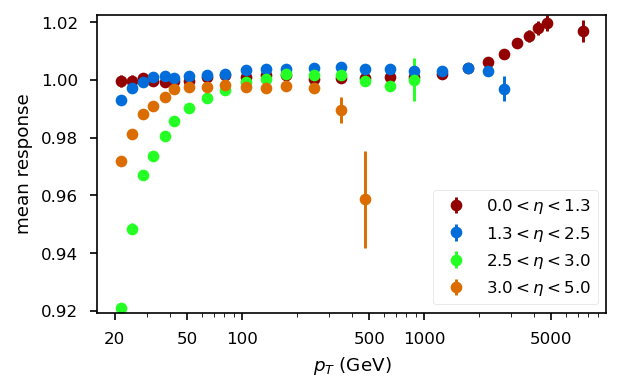

-------------------------
-------------------------
Fitting subsample:  _b
Images will be saved under  fig/response_pt_eta_b_L5_QCD-JME
N converge =  73 N_not_converge =  0


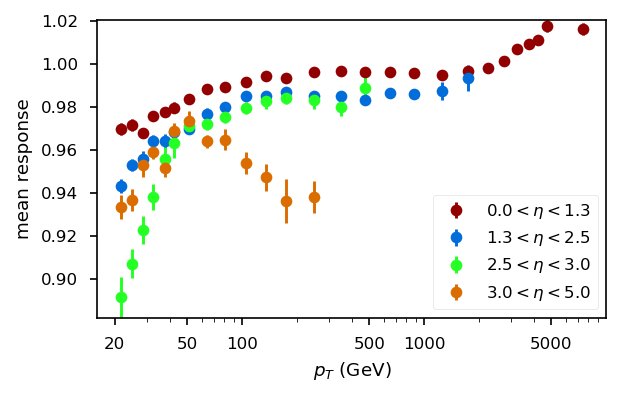

-------------------------
-------------------------
Fitting subsample:  _c
Images will be saved under  fig/response_pt_eta_c_L5_QCD-JME
N converge =  76 N_not_converge =  0


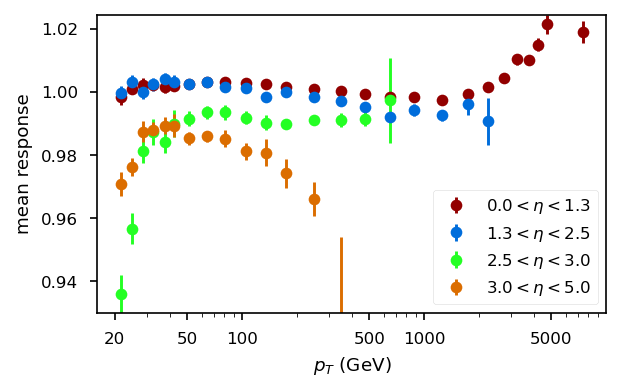

-------------------------
-------------------------
Fitting subsample:  _ud
Images will be saved under  fig/response_pt_eta_ud_L5_QCD-JME
N converge =  79 N_not_converge =  0


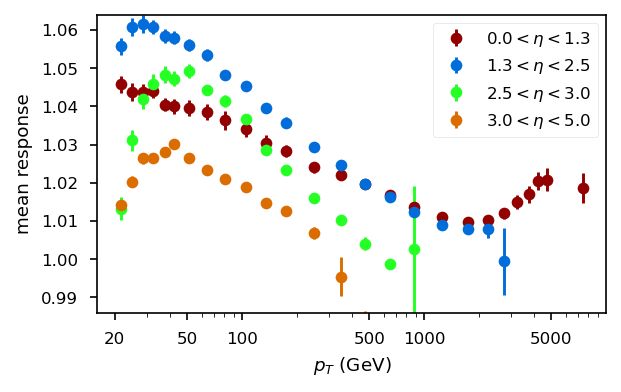

-------------------------
-------------------------
Fitting subsample:  _s
Images will be saved under  fig/response_pt_eta_s_L5_QCD-JME
N converge =  77 N_not_converge =  0


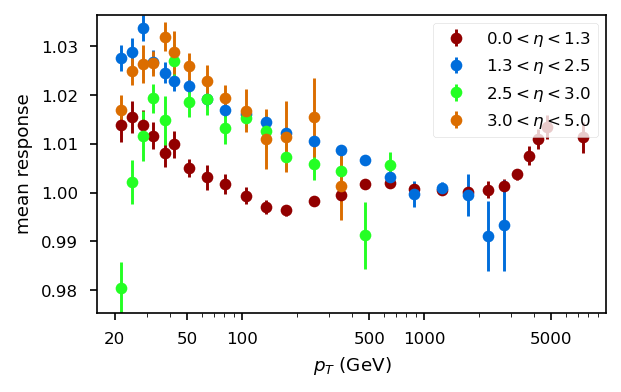

-------------------------
-------------------------
Fitting subsample:  _g
Images will be saved under  fig/response_pt_eta_g_L5_QCD-JME
N converge =  75 N_not_converge =  0


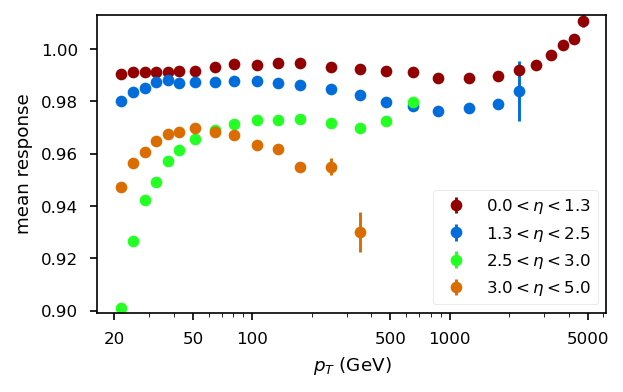

In [279]:
load_fit_res=False
subsamples = ['', '_b', '_c', '_ud', '_s', '_g']
# subsamples = ['', '_ud', '_g'] # , '_b']
for samp in subsamples:
    print('-'*25)
    print('-'*25)
    print('Fitting subsample: ', samp)
    if load_fit_res:
        mean = read_data("Mean", samp)
        meanvar = read_data("MeanVar", samp)
        median = read_data("Mean", samp)
        medianstd = read_data("MedianStd", samp)
#         width = read_data("Width")
#         median = read_data(median, "Median")
    else:
        mean, meanvar, median, medianstd = fit_responses(output, samp)
        for data, name in zip([mean, meanvar, median, medianstd],["Mean", "MeanVar", "Median", "MedianStd"]):
            save_data(data, name, samp)
            
    meanstd = np.sqrt(meanvar)
            
    if fine_etabins:
        plot_corrections_eta(median, samp, medianstd)
    else:
        plot_corrections(mean, samp, meanstd)

In [287]:
# etabins

In [234]:
len(etabins_c)
len(medianstd[2])
len(mean[2])

41

41

41

In [275]:
# # load_fit_res=False
# subsamples = ['', '_b', '_c', '_ud', '_s', '_g']
# subsamples = ['', '_ud', '_g'] # , '_b']
# for samp in subsamples:
#     print('-'*25)
#     print('-'*25)
#     print('Fitting subsample: ', samp)
#     if load_fit_res:
#         mean = read_data("Mean", samp)
#         meanvar = read_data("MeanVar", samp)
#         median = read_data("Mean", samp)
#         medianstd = read_data("MedianStd", samp)
# #         width = read_data("Width")
# #         median = read_data(median, "Median")
#     else:
#         mean, meanvar, median, medianstd = fit_responses(output, samp)
#         for data, name in zip([mean, meanvar, median, medianstd],["Mean", "MeanVar", "Median", "MedianStd"]):
#             save_data(data, name, samp)
            
#     plot_corrections(mean, samp, meanvar)

### Fitting the mean responses

In [26]:
samp = '_b'
etabin = 1

mean = read_data("Mean", samp)
meanvar = read_data("MeanVar", samp)

In [190]:
means = mean[:, etabin]
means2fit = means[means!=0.0]
ptbins2fit = ptbins[:-1][means!=0.0]
meanvar2fit = np.abs(meanvar[means!=0.0,etabin])

xvals = np.linspace(ptbins2fit.min() - (0.5), ptbins2fit.max()+(ptbins2fit[-1]-ptbins2fit[-11]),1000)

In [191]:
import scipy as sp

In [192]:
def ptscale2int(x, ptbins):
    ptmax = max(np.log10(ptbins))
    ptmin = min(np.log10(ptbins))
    z = np.log10(x)
    return ((z-ptmin)-(ptmax-z))/(ptmax-ptmin);

# def int2pt(z, ptbins):
#     Mi = np.min(np.log10(ptbins))
#     Ma = np.max(np.log10(ptbins))
#     pts = z/2*(Ma-Mi) + (Ma + Mi)/2
#     return 10**pts

In [193]:
def sum_cheb_tmp(x, ptbins, *p):
    c0, c1, c2, c3, c4 = p
    xs = ptscale2int(x, ptbins)
    res = (c0 * sp.special.eval_chebyt(0, xs) +
           c1 * sp.special.eval_chebyt(1, xs) + 
           c2 * sp.special.eval_chebyt(2, xs) + 
           c3 * sp.special.eval_chebyt(3, xs) + 
           c4 * sp.special.eval_chebyt(4, xs) )
    return res

def sum_cheb5_tmp(x, ptbins, *p):
    c0, c1, c2, c3, c4, c5 = p
    xs = ptscale2int(x, ptbins)
    res = (c0 * sp.special.eval_chebyt(0, xs) +
           c1 * sp.special.eval_chebyt(1, xs) + 
           c2 * sp.special.eval_chebyt(2, xs) + 
           c3 * sp.special.eval_chebyt(3, xs) + 
           c4 * sp.special.eval_chebyt(4, xs) + 
           c5 * sp.special.eval_chebyt(5, xs) )
    return res

def sum_cheb3_tmp(x, ptbins, *p):
    c0, c1, c2, c3 = p
    xs = ptscale2int(x, ptbins)
    res = (c0 * sp.special.eval_chebyt(0, xs) +
           c1 * sp.special.eval_chebyt(1, xs) + 
           c2 * sp.special.eval_chebyt(2, xs) + 
           c3 * sp.special.eval_chebyt(3, xs) )
    return res

def sum_cheb2_tmp(x, ptbins, *p):
    c0, c1, c2 = p
    xs = ptscale2int(x, ptbins)
    res = (c0 * sp.special.eval_chebyt(0, xs) +
           c1 * sp.special.eval_chebyt(1, xs) + 
           c2 * sp.special.eval_chebyt(2, xs) )
    return res

In [194]:
def response_fnc(x, *p):
    p0, p1, p2, p3, p4, p5 = p
    return p0+(p1/((np.log10(x)**2)+p2)) + (p3*np.exp(-p4*((np.log10(x)-p5)*(np.log10(x)-p5))))
#     return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [195]:
# def response_fnc1(x, *p):
#     p0, p1, p2, p3, p4, p5 = p
#     return (p0+(p1/((np.log10(x)**2)+p2)))
# def response_fnc2(x, *p):
#     p0, p1, p2, p3, p4, p5 = p
#     return (p3*np.exp(-(p4*((np.log10(x)-p5)*(np.log10(x)-p5)))))
# #     return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [196]:
init_vals_2014 = {
    'b':
    [[0.540002, 13.8495, 17.8549, -0.215711, 0.576285, 1.42258],
    [0.73119, 7.52866, 17.3681, -0.078402, 1.21665, 1.69878],
    [0.999952, 0.0322738, -1.05606, -19.6994, 0.720321, -1.58314],
    [0.135913, 7.92441, 3.85698, -0.804604, 1.11911, 0.732041]],
    'c' :
    [[ 0.940259, 0.705481, 0.23917, -0.826926, 0.311473, -0.514041],
    [0.982083, 0.238007, 4.35924, -0.0314618, 5.91028, 1.67749],
    [0.733505, 7.26794, 12.2028, -0.756302, 0.0895257, -1.96324],
    [0.932305, 1.15954, 17.1731, -0.471313, 2.58424, 0.254917]],
    'g' :
    [[0.877892, 3.10194, 1.16568, -677.876, 0.0325026, -12.9485],
    [0.983775, 0.247943, 1.55373, -0.0254802, 3.35748, 1.71263],
    [-0.972548, 38.8683, 2.47151, -44.0233, 0.0901665, -3.15495],
    [1.0655, -0.0680325, -0.509038, -8.59434e+06, 42.6162, 0.357177]],
    'l':
    [[1.28488, -46.3648, 151.749, -0.0108461, 15.4256, 1.63377],
    [ 1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581],
    [0.692016, 8.26488, 11.1655, -0.802769, 0.116182, -1.16094],
    [1.01244, -0.0926519, -0.12138, -3.69494e+07, 7.15634, -0.625288]],   
}

Better starting fit values I found

In [197]:
init_vals_2014['b'][0] = [ 9.81014871e-01, -6.46744813e-03, -1.05658840e+00,  5.35445486e+03, 2.99200015e+01,  1.21399356e+02]
init_vals_2014['b'][3] = [ 9.81014871e-01, -6.46744813e-03, -1.05658840e+00,  5.35445486e+03, 2.99200015e+01,  1.21399356e+02]

In [198]:
# init_vals_2014

In [199]:
# samp = '_c'
# etabin = 0

In [200]:
# subsamples = ['_b', '_c', '_l', '_g']
# subsamples = ['','_b', '_c', '_l', '_g']


In [201]:
# mean = read_data("Mean", samp)[:,etabin]
# meanvar = read_data("MeanVar", samp)[:,etabin]

# mean_range_pt = range(15,len(mean)-8)
# mean_range = mean_range_pt[:-1]

# ptbins2fit = ptbins[mean_range_pt]
# ptbins2fit = (ptbins2fit[:-1]+ptbins2fit[1:])/2
# means = mean[mean_range]

# means2fit = means[means!=0.0]
# ptbins2fit = ptbins2fit[means!=0.0]
# meanvar2fit = np.abs(meanvar[mean_range][means!=0.0])

In [202]:
def sum_cheb_tmp(x, ptbins, *p):
    c0, c1, c2, c3, c4 = p
    xs = ptscale2int(x, ptbins)
    res = (c0 * sp.special.eval_chebyt(0, xs) +
           c1 * sp.special.eval_chebyt(1, xs) + 
           c2 * sp.special.eval_chebyt(2, xs) + 
           c3 * sp.special.eval_chebyt(3, xs) + 
           c4 * sp.special.eval_chebyt(4, xs) )
    return res

In [204]:
# # for samp in subsamples:
# #     for etabin in range(4):
# samp = '_b'
# etabin = 3
# mean = read_data("Mean", samp)[:,etabin]
# meanvar = read_data("MeanVar", samp)[:,etabin]

# mean_range_pt = range(15,len(mean)-7)
# mean_range = mean_range_pt[:-1]

# ptbins2fit = ptbins[mean_range_pt]
# ptbins2fit = (ptbins2fit[:-1]+ptbins2fit[1:])/2
# means = mean[mean_range]

# means2fit = means[means!=0.0]
# ptbins2fit = ptbins2fit[means!=0.0]
# meanvar2fit = np.abs(meanvar[mean_range][means!=0.0])

# xvals = np.linspace(ptbins2fit.min() - (1), ptbins2fit.max()+(ptbins2fit[-1]-ptbins2fit[-11]),1000)
# def sum_cheb(x, *p):
#     return sum_cheb_tmp(x, ptbins2fit, *p)
# def sum_cheb5(x, *p):
#     return sum_cheb5_tmp(x, ptbins2fit, *p)    
# def sum_cheb3(x, *p):
#     return sum_cheb3_tmp(x, ptbins2fit, *p)  
# def sum_cheb2(x, *p):
#     return sum_cheb2_tmp(x, ptbins2fit, *p)  

# try:
#     p_resp, arr = curve_fit(response_fnc, ptbins2fit, means2fit, p0=[ 9.81014871e-01, -6.46744813e-03, -1.05658840e+00,  5.35445486e+03, 2.99200015e+01,  1.21399356e+02]) # init_vals_2014[samp[-1:]][etabin]) #0.793149, 4.60568, 11.1553, -0.123262, 0.878497, 1.52041
#     p_resp_err, arr = curve_fit(response_fnc, ptbins2fit, means2fit, p0=p_resp, sigma=np.sqrt(meanvar2fit))
# except(RuntimeError):
#     print("Winter 14 fit failed")
#     p_resp, p_resp_err = [[np.nan]*6]*2
# #      = np.nan*6

# # p_resp_err
# p_cheb1, arr = curve_fit(sum_cheb, ptbins2fit, means2fit, p0=[ 1, 1, 1, 1, 1])
# p_cheb, arr = curve_fit(sum_cheb, ptbins2fit, means2fit, p0=p_cheb1, sigma=np.sqrt(meanvar2fit))
# p_cheb5_1, arr = curve_fit(sum_cheb5, ptbins2fit, means2fit, p0=[ 1, 1, 1, 1, 1, 1])
# p_cheb5, arr = curve_fit(sum_cheb5, ptbins2fit, means2fit, p0=p_cheb5_1, sigma=np.sqrt(meanvar2fit))
# p_cheb3_1, arr = curve_fit(sum_cheb3, ptbins2fit, means2fit, p0=[ 1, 1, 1, 1])
# p_cheb3, arr = curve_fit(sum_cheb3, ptbins2fit, means2fit, p0=p_cheb3_1, sigma=np.sqrt(meanvar2fit))
# p_cheb2_1, arr = curve_fit(sum_cheb2, ptbins2fit, means2fit, p0=[ 1, 1, 1])
# p_cheb2, arr = curve_fit(sum_cheb2, ptbins2fit, means2fit, p0=p_cheb2_1, sigma=np.sqrt(meanvar2fit))

# yvals_resp = response_fnc(xvals, *p_resp)
# yvals_resp_err = response_fnc(xvals, *p_resp_err)
# # yvals_resp_err = response_fnc(xvals, *[0.530002, 13.8495, 17.8549, -0.215711, 0.576285, 1.42258])
# yvals = sum_cheb(xvals, *p_cheb)
# #         yvals1 = sum_cheb(xvals, *p_cheb1)
# yvalsC5 = sum_cheb5(xvals, *p_cheb5)
# #         yvalsC5_1 = sum_cheb5(xvals, *p_cheb5_1)
# yvalsC3 = sum_cheb3(xvals, *p_cheb3)
# yvalsC2 = sum_cheb2(xvals, *p_cheb2)

# chi2_resp = np.sum((response_fnc(ptbins2fit, *p_resp_err) - means2fit)**2/meanvar2fit)
# chi2_C4 = np.sum((sum_cheb(ptbins2fit, *p_cheb) - means2fit)**2/meanvar2fit)
# chi2_C5 = np.sum((sum_cheb5(ptbins2fit, *p_cheb5) - means2fit)**2/np.abs(meanvar2fit))
# chi2_C3 = np.sum((sum_cheb3(ptbins2fit, *p_cheb3) - means2fit)**2/np.abs(meanvar2fit))
# chi2_C2 = np.sum((sum_cheb2(ptbins2fit, *p_cheb2) - means2fit)**2/np.abs(meanvar2fit))
# Ndof_C4 = len(ptbins2fit) - 5
# Ndof_C5 = len(ptbins2fit) - 6
# Ndof_C3 = len(ptbins2fit) - 4
# Ndof_C2 = len(ptbins2fit) - 3
# Ndof_resp = len(ptbins2fit) - 6


# fig, ax = plt.subplots()

# plt.errorbar(ptbins2fit, means2fit, yerr=np.sqrt(np.abs(meanvar2fit)), marker='o',
#              linestyle="none", label=f'Data {etabins_mod[etabin]}'+r'$<\eta<'+f'${etabins_mod[etabin+1]}')

# eta_string = '_eta'+str(etabins_mod[etabin])+'to'+str(etabins_mod[etabin+1])
# eta_string = eta_string.replace('.','')
# if np.isnan(chi2_resp): 
#     winter14_lab = 'Winter14 func, failed'
# else:
#     winter14_lab= 'Winter14 func, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_resp, Ndof_resp)

# # yvals_resp_err = response_fnc(xvals, *[ 9.81014871e-01, -6.46744813e-03, -1.05658840e+00,  5.35445486e+03,
# #         2.99200015e+01,  1.21399356e+02])
# ax.plot(xvals, yvals_resp_err, label=winter14_lab, linewidth=1.8);
# ax.plot(xvals, yvals, label=r'Chebyshev, n=4, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C4, Ndof_C4),linewidth=1.8);
# #         ax.plot(xvals, yvalsC5, label=r'Chebyshev, n=5, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C5, Ndof_C5),linewidth=1.8);
# ax.plot(xvals, yvalsC3, label=r'Chebyshev, n=3, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C3, Ndof_C3),linewidth=1.8);
# ax.plot(xvals, yvalsC2, label=r'Chebyshev, n=2, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C2, Ndof_C2),linewidth=1.8);


# #         yerr_norm = np.concatenate([np.sqrt(meanvar[start:,[k2, k4, k6, k8]]) ])
# #         y_norm = np.concatenate([mean_p[start:,[k2, k4, k6, k8]]])
# #     print("ynorm = ", y_norm)
# #     print("yerr = ", yerr_norm)
# std = np.sqrt(np.abs(meanvar2fit))
# norm_pos = (std<0.1) &  (std != np.inf)
# #     print("(yerr_norm+y_norm)[norm_pos]) = ", (yerr_norm+y_norm)[norm_pos])
# ax.set_ylim(np.min((means2fit-std)[norm_pos])-0.002 ,np.max((std+means2fit)[norm_pos])+0.002)

# ax.set_xlabel(r'$p_T$ (GeV)');
# ax.set_ylabel(r'mean response');
# ax.set_xscale('log')
# # ax.set_ylim([0.8,1.1])
# ax.legend(prop={'size': 7})
# # plt.savefig('fig/response_fit'+samp+eta_string+'.png', dpi=plt.rcParamsDefault['figure.dpi']);
# # plt.savefig('fig/response_fit'+samp+eta_string+'.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
# # fig.set_size_inches(6, 4, forward=True)
# plt.show();
# 'a';

Winter 14 fit failed


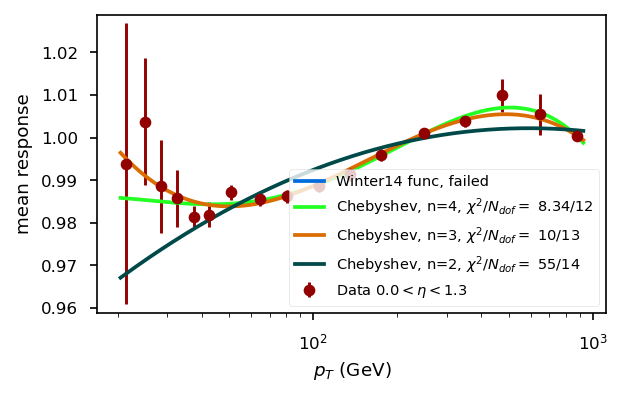

Winter 14 fit failed


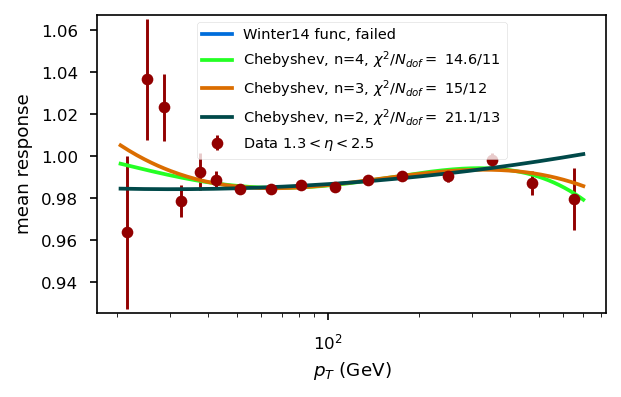

Winter 14 fit failed


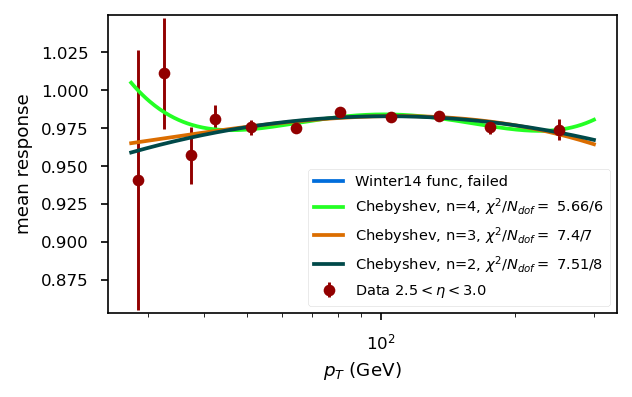

/opt/conda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


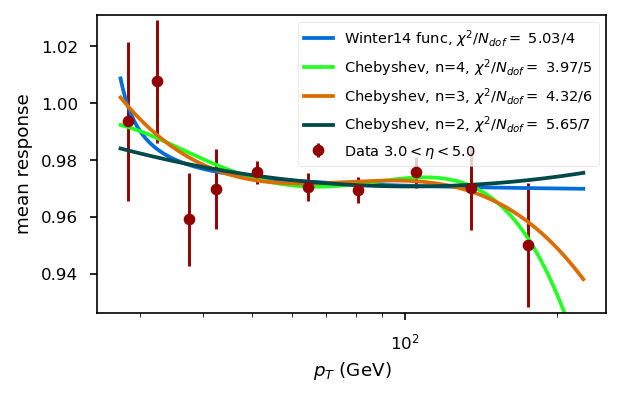

/tmp/anpotreb/ipykernel_31327/4222208775.py:3: RuntimeWarning: overflow encountered in exp
  return p0+(p1/((np.log10(x)**2)+p2)) + (p3*np.exp(-p4*((np.log10(x)-p5)*(np.log10(x)-p5))))


Winter 14 fit failed


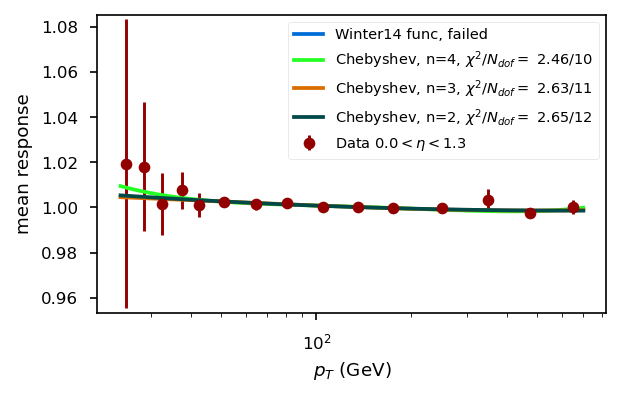

/opt/conda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


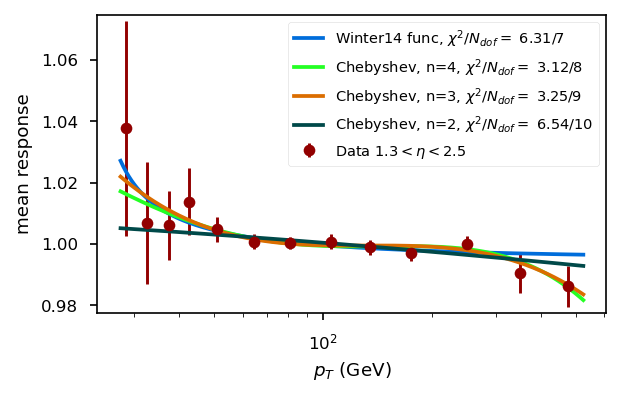

Winter 14 fit failed


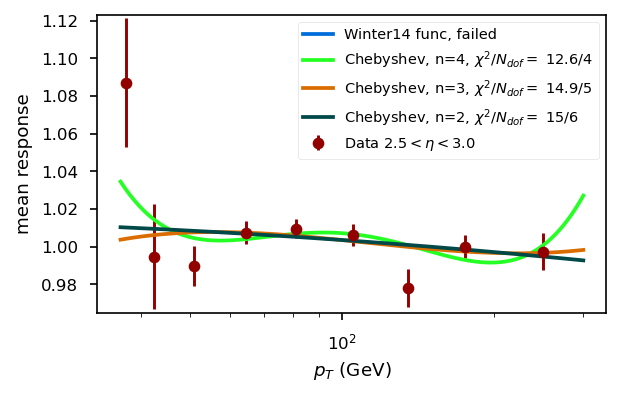

/tmp/anpotreb/ipykernel_31327/4222208775.py:3: RuntimeWarning: overflow encountered in exp
  return p0+(p1/((np.log10(x)**2)+p2)) + (p3*np.exp(-p4*((np.log10(x)-p5)*(np.log10(x)-p5))))


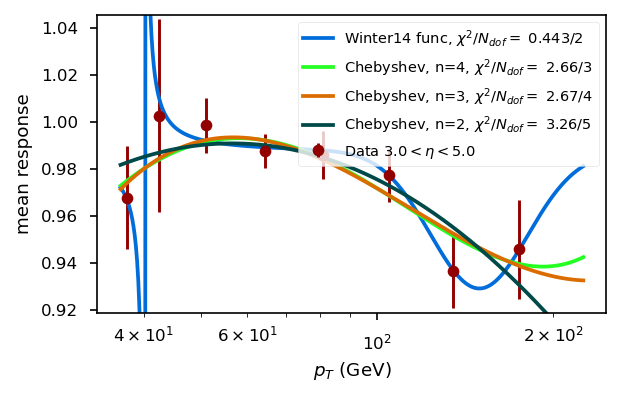

In [346]:
subsamples = ['_b', '_c', '_l', '_g']
subsamples = ['_b', '_c']


for samp in subsamples:
    for etabin in range(4):
        mean = read_data("Mean", samp)[:,etabin]
        meanvar = read_data("MeanVar", samp)[:,etabin]

        mean_range = range(15,len(mean)-8)
#         mean_range = mean_range_pt[:-1]

#         ptbins2fit = ptbins[mean_range_pt]
#         ptbins2fit = (ptbins2fit[:-1]+ptbins2fit[1:])/2
        means = mean[mean_range]
        ptbins2fit = ptbins_c[mean_range]

        means2fit = means[means!=0.0]
        ptbins2fit = ptbins2fit[means!=0.0]
        meanvar2fit = np.abs(meanvar[mean_range][means!=0.0])

        xvals = np.linspace(ptbins2fit.min() - (1), ptbins2fit.max()+50,1000) #-200 to plot the fitted curved outside of the points
        def sum_cheb(x, *p):
            return sum_cheb_tmp(x, ptbins2fit, *p)
        def sum_cheb5(x, *p):
            return sum_cheb5_tmp(x, ptbins2fit, *p)    
        def sum_cheb3(x, *p):
            return sum_cheb3_tmp(x, ptbins2fit, *p)  
        def sum_cheb2(x, *p):
            return sum_cheb2_tmp(x, ptbins2fit, *p)  
            
        try:
            p_resp, arr = curve_fit(response_fnc, ptbins2fit, means2fit, p0=init_vals_2014[samp[-1:]][etabin]) #0.793149, 4.60568, 11.1553, -0.123262, 0.878497, 1.52041
            p_resp_err, arr = curve_fit(response_fnc, ptbins2fit, means2fit, p0=p_resp, sigma=np.sqrt(meanvar2fit))
        except(RuntimeError):
            print("Winter 14 fit failed")
            p_resp, p_resp_err = [[np.nan]*6]*2
        #      = np.nan*6

        # p_resp_err
        p_cheb1, arr = curve_fit(sum_cheb, ptbins2fit, means2fit, p0=[ 1, 1, 1, 1, 1])
        p_cheb, arr = curve_fit(sum_cheb, ptbins2fit, means2fit, p0=p_cheb1, sigma=np.sqrt(meanvar2fit))
        p_cheb5_1, arr = curve_fit(sum_cheb5, ptbins2fit, means2fit, p0=[ 1, 1, 1, 1, 1, 1])
        p_cheb5, arr = curve_fit(sum_cheb5, ptbins2fit, means2fit, p0=p_cheb5_1, sigma=np.sqrt(meanvar2fit))
        p_cheb3_1, arr = curve_fit(sum_cheb3, ptbins2fit, means2fit, p0=[ 1, 1, 1, 1])
        p_cheb3, arr = curve_fit(sum_cheb3, ptbins2fit, means2fit, p0=p_cheb3_1, sigma=np.sqrt(meanvar2fit))
        p_cheb2_1, arr = curve_fit(sum_cheb2, ptbins2fit, means2fit, p0=[ 1, 1, 1])
        p_cheb2, arr = curve_fit(sum_cheb2, ptbins2fit, means2fit, p0=p_cheb2_1, sigma=np.sqrt(meanvar2fit))

        yvals_resp = response_fnc(xvals, *p_resp)
        yvals_resp_err = response_fnc(xvals, *p_resp_err)
        yvals = sum_cheb(xvals, *p_cheb)
#         yvals1 = sum_cheb(xvals, *p_cheb1)
        yvalsC5 = sum_cheb5(xvals, *p_cheb5)
#         yvalsC5_1 = sum_cheb5(xvals, *p_cheb5_1)
        yvalsC3 = sum_cheb3(xvals, *p_cheb3)
        yvalsC2 = sum_cheb2(xvals, *p_cheb2)

        chi2_resp = np.sum((response_fnc(ptbins2fit, *p_resp_err) - means2fit)**2/meanvar2fit)
        chi2_C4 = np.sum((sum_cheb(ptbins2fit, *p_cheb) - means2fit)**2/meanvar2fit)
        chi2_C5 = np.sum((sum_cheb5(ptbins2fit, *p_cheb5) - means2fit)**2/np.abs(meanvar2fit))
        chi2_C3 = np.sum((sum_cheb3(ptbins2fit, *p_cheb3) - means2fit)**2/np.abs(meanvar2fit))
        chi2_C2 = np.sum((sum_cheb2(ptbins2fit, *p_cheb2) - means2fit)**2/np.abs(meanvar2fit))
        Ndof_C4 = len(ptbins2fit) - 5
        Ndof_C5 = len(ptbins2fit) - 6
        Ndof_C3 = len(ptbins2fit) - 4
        Ndof_C2 = len(ptbins2fit) - 3
        Ndof_resp = len(ptbins2fit) - 6


        fig, ax = plt.subplots()

        plt.errorbar(ptbins2fit, means2fit, yerr=np.sqrt(np.abs(meanvar2fit)), marker='o',
                     linestyle="none", label=f'Data {etabins_mod[etabin]}'+r'$<\eta<'+f'${etabins_mod[etabin+1]}')

        eta_string = '_eta'+str(etabins_mod[etabin])+'to'+str(etabins_mod[etabin+1])
        eta_string = eta_string.replace('.','')
        if np.isnan(chi2_resp): 
            winter14_lab = 'Winter14 func, failed'
        else:
            winter14_lab= 'Winter14 func, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_resp, Ndof_resp)

        ax.plot(xvals, yvals_resp_err, label=winter14_lab, linewidth=1.8);
        ax.plot(xvals, yvals, label=r'Chebyshev, n=4, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C4, Ndof_C4),linewidth=1.8);
#         ax.plot(xvals, yvalsC5, label=r'Chebyshev, n=5, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C5, Ndof_C5),linewidth=1.8);
        ax.plot(xvals, yvalsC3, label=r'Chebyshev, n=3, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C3, Ndof_C3),linewidth=1.8);
        ax.plot(xvals, yvalsC2, label=r'Chebyshev, n=2, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C2, Ndof_C2),linewidth=1.8);

    
#         yerr_norm = np.concatenate([np.sqrt(meanvar[start:,[k2, k4, k6, k8]]) ])
#         y_norm = np.concatenate([mean_p[start:,[k2, k4, k6, k8]]])
    #     print("ynorm = ", y_norm)
    #     print("yerr = ", yerr_norm)
        std = np.sqrt(np.abs(meanvar2fit))
        norm_pos = (std<0.1) &  (std != np.inf)
    #     print("(yerr_norm+y_norm)[norm_pos]) = ", (yerr_norm+y_norm)[norm_pos])
        ax.set_ylim(np.min((means2fit-std)[norm_pos])-0.002 ,np.max((std+means2fit)[norm_pos])+0.002)

        ax.set_xlabel(r'$p_T$ (GeV)');
        ax.set_ylabel(r'mean response');
        ax.set_xscale('log')
        # ax.set_ylim([0.8,1.1])
        ax.legend(prop={'size': 7})
        if not test_run:
            plt.savefig('fig/response_fit'+samp+eta_string+'.png', dpi=plt.rcParamsDefault['figure.dpi']);
            plt.savefig('fig/response_fit'+samp+eta_string+'.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
        else:
            plt.savefig('test/fig/response_fit'+samp+eta_string+'.png', dpi=plt.rcParamsDefault['figure.dpi']);
            plt.savefig('test/fig/response_fit'+samp+eta_string+'.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
        # fig.set_size_inches(6, 4, forward=True)
        plt.show();
        plt.close();
'a';

### Playground with fitting and plotting

In [49]:
def read_data(name, samp, tag_full):
#     if not test_run:
    df_csv = pd.read_csv('out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'.csv').set_index('etaBins')
#         df.to_csv('out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'.csv')
#     else: #before_closure/
#     df_csv = pd.read_csv('test/out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'_test.csv').set_index('etaBins')
#         df.to_csv('out_txt/EtaBinsvsPtBins'+name+tag+'_test.csv')
    
#     df_csv = pd.read_csv('out_txt/EtaBinsvsPtBinsMean_L5.csv').set_index('etaBins')
    data = df_csv.to_numpy().transpose()
    return data

In [69]:
def make_comparison_plot(yvar1, std1, yvar2, std2, k, samp, name1:str, name2:str):
    ''' Make a coparison and a ratio plot of yvar2 vs yvar1
    '''
    
    mean_p_QCD = yvar1.copy()
    mean_p_QCD[(mean_p_QCD==0) | (np.abs(mean_p_QCD)==np.inf)] = np.nan
    
    mean_p_TTBAR = yvar2.copy()
    mean_p_TTBAR[(mean_p_TTBAR==0) | (np.abs(mean_p_TTBAR)==np.inf)] = np.nan

    fig = plt.figure()
    gs = fig.add_gridspec(nrows=2, ncols=1, hspace=0, height_ratios=[3, 1])
    ax = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    start = np.where(ptbins<=20)[0][-1]

    for axis in [ax.xaxis, ax.yaxis, ax2.xaxis, ax2.yaxis]:
        axis.set_minor_locator(mpl.ticker.AutoMinorLocator())

    xvals = (ptbins[start:-1] + ptbins[start+1:])/2
    wd = np.abs(ptbins[start:-1] - ptbins[start+1:])
    QCD_vals = mean_p_QCD[start:,k]
    TTbar_vals = mean_p_TTBAR[start:,k]

    print(xvals)
    print(QCD_vals)
    p1 = ax.errorbar(xvals, QCD_vals, yerr=std1[start:,k], marker='o',
#                      markerfacecolor='none', markeredgewidth=1,
                 linestyle="none", label=name1)

    p5 = ax.errorbar(xvals, TTbar_vals, yerr=std2[start:,k], marker='v',
#                      markerfacecolor='none', markeredgewidth=1, color=p1.lines[0].get_color(),
                 linestyle="none", label=name2)

    ax2.hlines(1,1, 10000, linestyles='--',color="black",
        linewidth=1,)
    rel_mc_unc =  std1[start:,k]/QCD_vals 

    ax2.bar(
        xvals,
        2 * rel_mc_unc,
        width=wd,
        bottom=1.0 - rel_mc_unc,
        fill=False,
        linewidth=0,
        edgecolor="gray",
        hatch=10 * "/",
    )


    # data in ratio plot
    data_model_ratio = TTbar_vals/QCD_vals
    data_model_ratio_unc = std2[start:,k] / QCD_vals
    # mask data in bins where total model yield is 0
    ax2.errorbar(
        xvals,
        data_model_ratio, #[nonzero_model_yield],
        yerr=data_model_ratio_unc, #[nonzero_model_yield],
        fmt="o",
        color="k",
    )


    ax2.set_ylabel(name2+" /\n "+name1)
    ax2.tick_params(axis="both", which="major", pad=8)
    ax2.tick_params(direction="in", top=True, right=True, which="both")

    fig.set_tight_layout(True)

    ### Calculate resonable limits excluding the few points with insane errors
    yerr_norm = np.concatenate([std1[start:,k], std2[start:,k] ])
    y_norm = np.concatenate([QCD_vals, TTbar_vals])
    norm_pos = (yerr_norm<0.04) &  (yerr_norm != np.inf) & (y_norm>-0.1)
    ax.set_ylim(np.min((y_norm-yerr_norm)[norm_pos]), np.max((yerr_norm+y_norm)[norm_pos]))

    yerr_norm = np.concatenate([std1[start:,k]/QCD_vals, std2[start:,k]/QCD_vals ])
    y_norm = np.concatenate([QCD_vals/QCD_vals, TTbar_vals/QCD_vals])
    norm_pos = (yerr_norm<0.03) &  (yerr_norm != np.inf) & (y_norm>-0.1) 
    ax2.set_ylim(np.min((y_norm-yerr_norm)[norm_pos]), np.max((yerr_norm+y_norm)[norm_pos]))

    ax2.set_xlabel(r'$p_T$ (GeV)');
    ax.set_ylabel(r'median response');
    ax.set_xscale('log')
    ax2.set_xscale('log')

    ax.set_xticks([])
    ax2.set_xticks([20, 50, 100, 500, 1000, 5000])
    ax2.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    leg1 = ax.legend()

    ax2.set_xlim(ax.get_xlim())
    eta_string = '_eta'+str(etabins_mod[k])+'to'+str(etabins_mod[k+1])
    eta_string = eta_string.replace('.','')
    print("Saving plot for eta = ", eta_string)
    fig_name = 'fig/corr_vs_pt'+samp+eta_string+'_L5_'+name1+'-'+name2+'-median'
    print("Saving plot with the name = ", fig_name)
    plt.savefig(fig_name+'.pdf');
    plt.savefig(fig_name+'.png');
    # gs1.tight_layout(fig, rect=[0, 0.1, 0.8, 0.5])
    plt.show();

Fitting subsample:  
Eta:  0
[  21.5   25.    28.5   32.5   37.5   42.5   51.    64.5   81.   105.
  135.   175.   250.   350.   475.   650.   875.  1250.  1750.  2250.
 2750.  3250.  3750.  4250.  4750.  7500. ]
[1.00674873 1.00643472 1.00687556 1.00622114 1.00543455 1.00554345
 1.00510941 1.00419657 1.0023908  1.0005354  1.00037977 0.99896498
 0.998727   0.99799153 0.99978744 0.99881657 1.00016779        nan
        nan        nan        nan        nan        nan        nan
        nan        nan]
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_eta00to13_L5_Pythia-Herwig-median


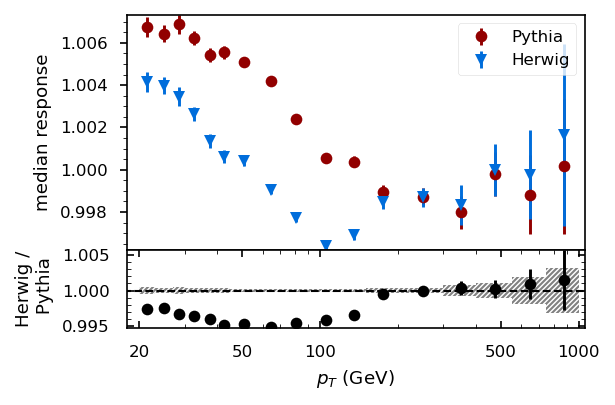

Fitting subsample:  
Eta:  1
[  21.5   25.    28.5   32.5   37.5   42.5   51.    64.5   81.   105.
  135.   175.   250.   350.   475.   650.   875.  1250.  1750.  2250.
 2750.  3250.  3750.  4250.  4750.  7500. ]
[0.9999788  1.00388922 1.00467529 1.00440729 1.00554277 1.00348116
 1.00348351 1.00053836 0.99905291 0.99802225 0.99771351 0.99764836
 0.99765562 0.99836507 0.99819048 0.99746503        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan]
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_eta13to25_L5_Pythia-Herwig-median


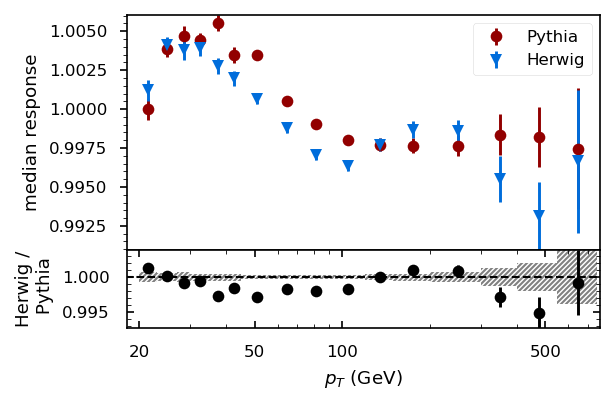

Fitting subsample:  
Eta:  2
[  21.5   25.    28.5   32.5   37.5   42.5   51.    64.5   81.   105.
  135.   175.   250.   350.   475.   650.   875.  1250.  1750.  2250.
 2750.  3250.  3750.  4250.  4750.  7500. ]
[0.93400788 0.95570644 0.96503204 0.97710368 0.98536258 0.98820164
 0.99094628 0.99483849 0.99496088 0.99623843 0.9966864  1.00019401
 0.99983766 0.99852151 0.9975            nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan]
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_eta25to30_L5_Pythia-Herwig-median


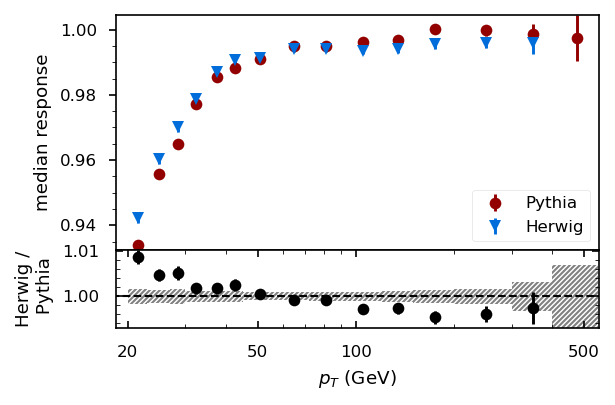

Fitting subsample:  
Eta:  3
[  21.5   25.    28.5   32.5   37.5   42.5   51.    64.5   81.   105.
  135.   175.   250.   350.   475.   650.   875.  1250.  1750.  2250.
 2750.  3250.  3750.  4250.  4750.  7500. ]
[0.9612834  0.97242685 0.97812717 0.9851383  0.99190708 0.99289925
 0.9941766  0.99540731 0.9960119  0.99698524 0.99821616 0.9997955
 1.00044014        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan]
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_eta30to50_L5_Pythia-Herwig-median


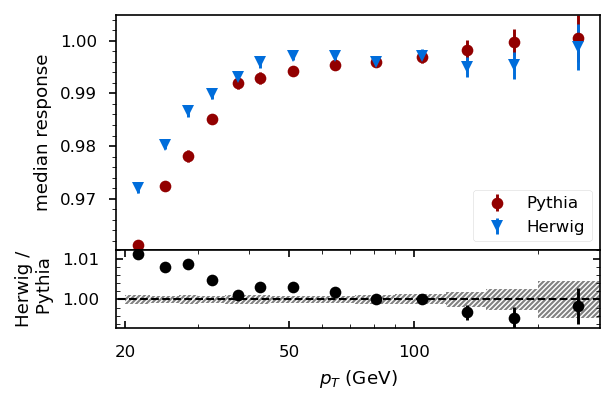

Fitting subsample:  _b
Eta:  0
[  21.5   25.    28.5   32.5   37.5   42.5   51.    64.5   81.   105.
  135.   175.   250.   350.   475.   650.   875.  1250.  1750.  2250.
 2750.  3250.  3750.  4250.  4750.  7500. ]
[0.97799629 0.97384603 0.97427862 0.97429627 0.97502726 0.97811345
 0.98051725 0.98464366 0.9868838  0.98854749 0.99140868 0.9921124
 0.99200405 0.99276596 0.99475806        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan]
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_b_eta00to13_L5_Pythia-Herwig-median


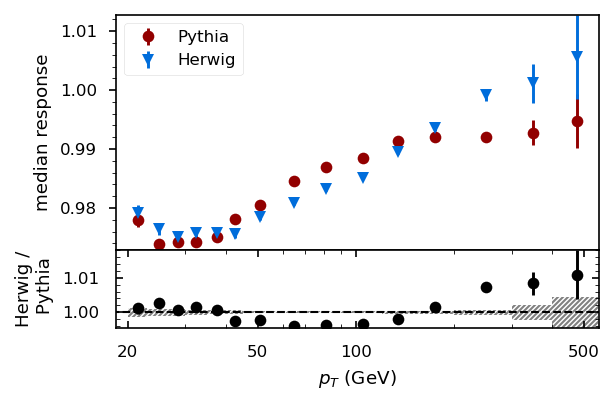

Fitting subsample:  _b
Eta:  1
[  21.5   25.    28.5   32.5   37.5   42.5   51.    64.5   81.   105.
  135.   175.   250.   350.   475.   650.   875.  1250.  1750.  2250.
 2750.  3250.  3750.  4250.  4750.  7500. ]
[0.96651167 0.96465556 0.96508955 0.96493661 0.96850214 0.967173
 0.97190194 0.97359941 0.97626807 0.97937991 0.98277346 0.98341923
 0.98326886 0.98403465        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan]
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_b_eta13to25_L5_Pythia-Herwig-median


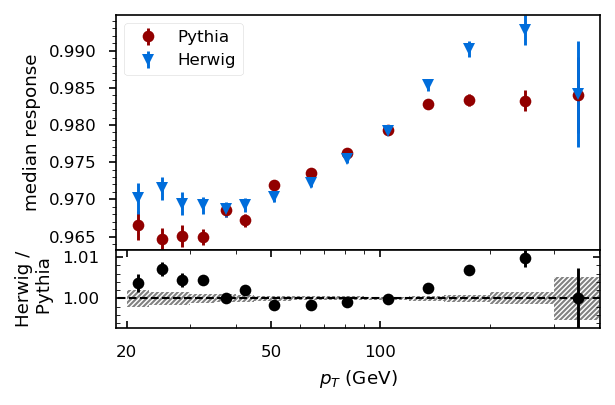

Fitting subsample:  _b
Eta:  2
[  21.5   25.    28.5   32.5   37.5   42.5   51.    64.5   81.   105.
  135.   175.   250.   350.   475.   650.   875.  1250.  1750.  2250.
 2750.  3250.  3750.  4250.  4750.  7500. ]
[0.90625    0.91935318 0.93416667 0.9449183  0.95655575 0.95885149
 0.9658326  0.97271091 0.97531595 0.97988476 0.97998162 0.98307292
 0.97854167        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan]
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_b_eta25to30_L5_Pythia-Herwig-median


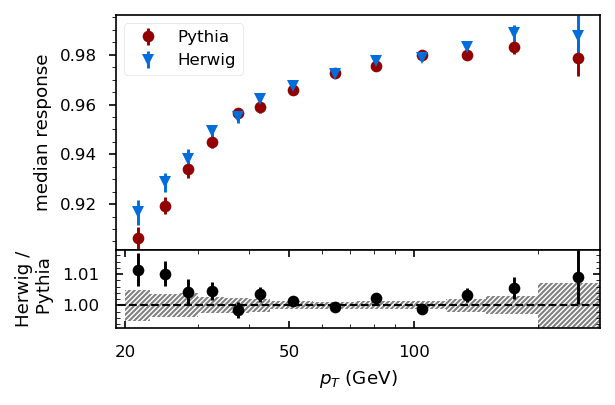

Fitting subsample:  _b
Eta:  3
[  21.5   25.    28.5   32.5   37.5   42.5   51.    64.5   81.   105.
  135.   175.   250.   350.   475.   650.   875.  1250.  1750.  2250.
 2750.  3250.  3750.  4250.  4750.  7500. ]
[0.92205056 0.9288674  0.93953729 0.94128086 0.95249215 0.96111341
 0.95862034 0.96471053 0.96932678 0.97164474 0.96355263 0.97697368
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan]
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_b_eta30to50_L5_Pythia-Herwig-median


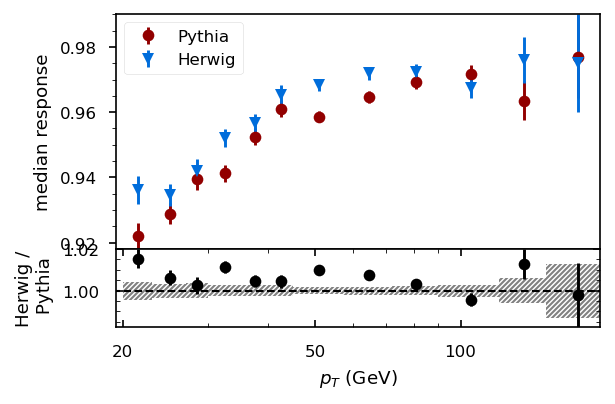

Fitting subsample:  _c
Eta:  0
[  21.5   25.    28.5   32.5   37.5   42.5   51.    64.5   81.   105.
  135.   175.   250.   350.   475.   650.   875.  1250.  1750.  2250.
 2750.  3250.  3750.  4250.  4750.  7500. ]
[1.012052   1.01122004 1.00931398 1.01064245 1.00899209 1.00984235
 1.01122465 1.0102609  1.00928115 1.00688933 1.0070785  1.0051052
 1.00341053 1.00115979 0.99975962        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan]
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_c_eta00to13_L5_Pythia-Herwig-median


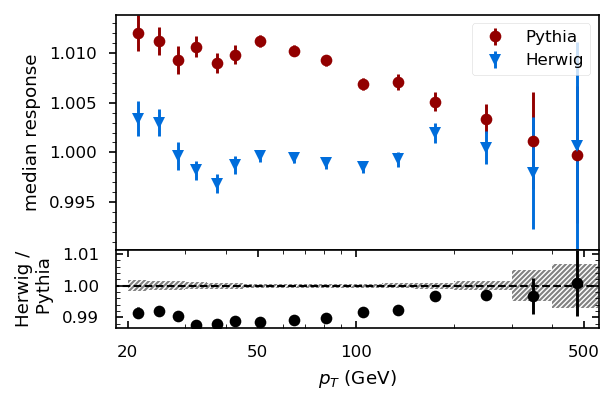

Fitting subsample:  _c
Eta:  1
[  21.5   25.    28.5   32.5   37.5   42.5   51.    64.5   81.   105.
  135.   175.   250.   350.   475.   650.   875.  1250.  1750.  2250.
 2750.  3250.  3750.  4250.  4750.  7500. ]
[1.01264022 1.01328521 1.01433501 1.00930813 1.01306405 1.01168728
 1.01252903 1.01192289 1.009509   1.00926097 1.00660338 1.00541796
 1.0015625  1.01477273        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan]
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_c_eta13to25_L5_Pythia-Herwig-median


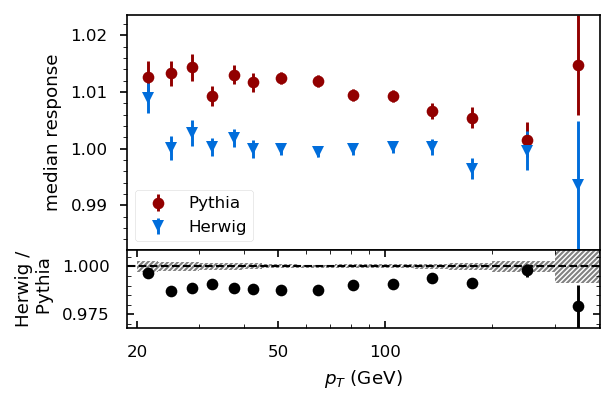

Fitting subsample:  _c
Eta:  2
[  21.5   25.    28.5   32.5   37.5   42.5   51.    64.5   81.   105.
  135.   175.   250.   350.   475.   650.   875.  1250.  1750.  2250.
 2750.  3250.  3750.  4250.  4750.  7500. ]
[0.97528846 0.99301242 1.0005137  1.01048729 1.01525974 1.01206226
 1.01632379 1.01489362 1.01581126 1.01503247 1.00898973 1.00608108
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan]
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_c_eta25to30_L5_Pythia-Herwig-median


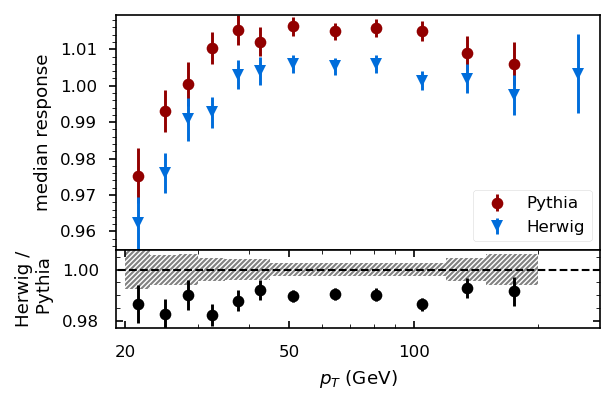

Fitting subsample:  _c
Eta:  3
[  21.5   25.    28.5   32.5   37.5   42.5   51.    64.5   81.   105.
  135.   175.   250.   350.   475.   650.   875.  1250.  1750.  2250.
 2750.  3250.  3750.  4250.  4750.  7500. ]
[0.99358696 0.997      1.00825472 1.00597222 1.01180556 1.00797244
 1.01235119 1.00182161 1.00206522 1.00480769 1.00535714        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan]
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_c_eta30to50_L5_Pythia-Herwig-median


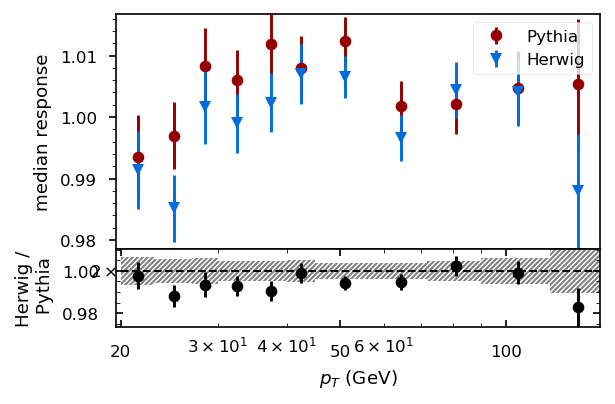

Fitting subsample:  _s
Eta:  0
[  21.5   25.    28.5   32.5   37.5   42.5   51.    64.5   81.   105.
  135.   175.   250.   350.   475.   650.   875.  1250.  1750.  2250.
 2750.  3250.  3750.  4250.  4750.  7500. ]
[1.02257301 1.01683834 1.01652513 1.01290364 1.01069123 1.0094767
 1.00830388 1.00533123 1.00183669 0.99930749 0.99678719 0.99669374
 0.99929435 0.99641304 1.00104167        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan]
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_s_eta00to13_L5_Pythia-Herwig-median


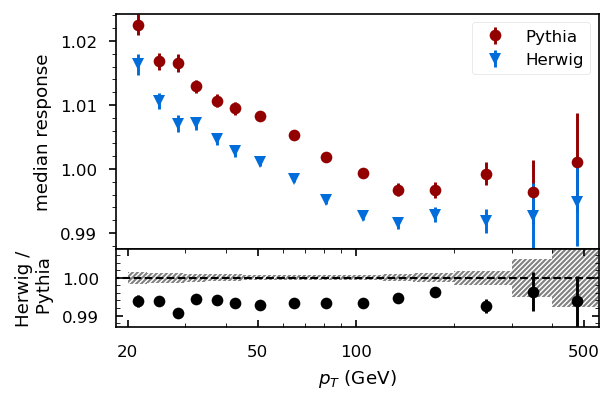

Fitting subsample:  _s
Eta:  1
[  21.5   25.    28.5   32.5   37.5   42.5   51.    64.5   81.   105.
  135.   175.   250.   350.   475.   650.   875.  1250.  1750.  2250.
 2750.  3250.  3750.  4250.  4750.  7500. ]
[1.03579193 1.03457515 1.03218172 1.03137964 1.02609406 1.02634628
 1.0232235  1.02037104 1.01675861 1.01446586 1.01100835 1.00737245
 1.00184426 0.99934211        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan]
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_s_eta13to25_L5_Pythia-Herwig-median


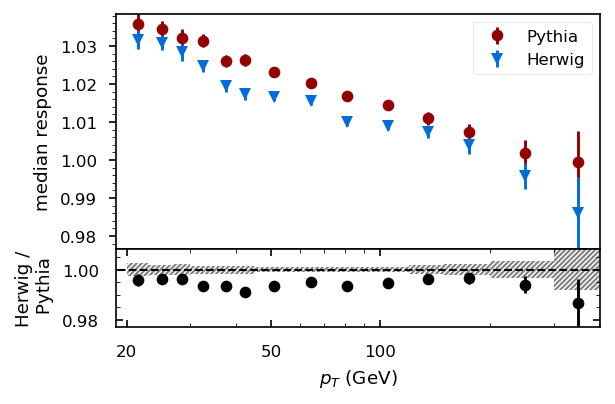

Fitting subsample:  _s
Eta:  2
[  21.5   25.    28.5   32.5   37.5   42.5   51.    64.5   81.   105.
  135.   175.   250.   350.   475.   650.   875.  1250.  1750.  2250.
 2750.  3250.  3750.  4250.  4750.  7500. ]
[1.0085177  1.035      1.03222222 1.03035714 1.03407258 1.04308628
 1.03313253 1.02450696 1.0222063  1.02671655 1.0130618  1.01038136
 1.00509259        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan]
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_s_eta25to30_L5_Pythia-Herwig-median


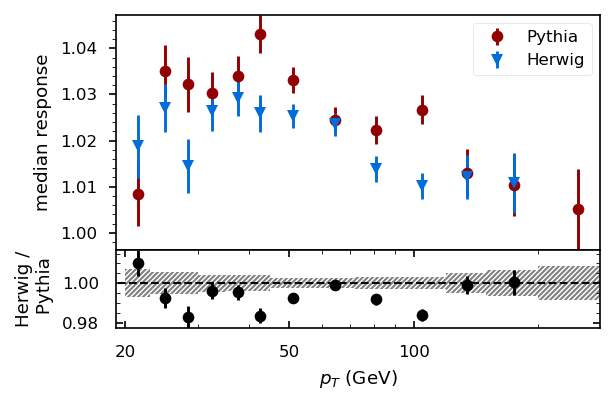

Fitting subsample:  _s
Eta:  3
[  21.5   25.    28.5   32.5   37.5   42.5   51.    64.5   81.   105.
  135.   175.   250.   350.   475.   650.   875.  1250.  1750.  2250.
 2750.  3250.  3750.  4250.  4750.  7500. ]
[1.03616412 1.05137097 1.04223485 1.04476562 1.06069079 1.05332168
 1.04777778 1.03933121 1.03686975 1.03482143 1.00833333        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan]
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_s_eta30to50_L5_Pythia-Herwig-median


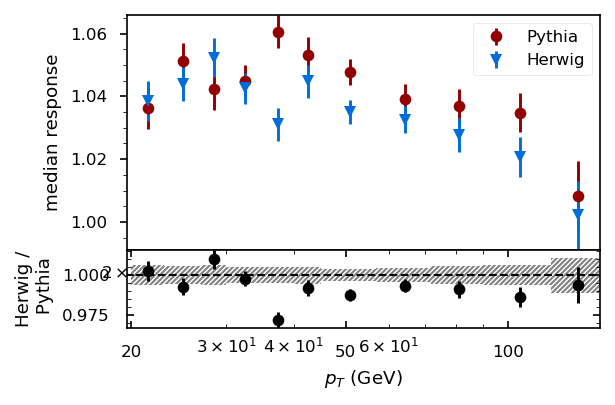

Fitting subsample:  _ud
Eta:  0
[  21.5   25.    28.5   32.5   37.5   42.5   51.    64.5   81.   105.
  135.   175.   250.   350.   475.   650.   875.  1250.  1750.  2250.
 2750.  3250.  3750.  4250.  4750.  7500. ]
[1.04716332 1.04320878 1.04130711 1.03901358 1.03728006 1.03696385
 1.03665484 1.03500053 1.03239849 1.02868379 1.02545124 1.02149401
 1.01877604 1.01621339 1.01688433 1.0127924  1.01333333        nan
        nan        nan        nan        nan        nan        nan
        nan        nan]
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_ud_eta00to13_L5_Pythia-Herwig-median


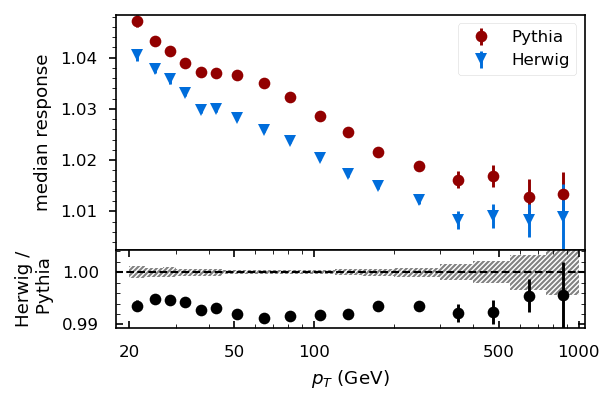

Fitting subsample:  _ud
Eta:  1
[  21.5   25.    28.5   32.5   37.5   42.5   51.    64.5   81.   105.
  135.   175.   250.   350.   475.   650.   875.  1250.  1750.  2250.
 2750.  3250.  3750.  4250.  4750.  7500. ]
[1.05976965 1.06121874 1.0582932  1.05657641 1.05532321 1.05185979
 1.05028438 1.04487678 1.04116155 1.03755011 1.03102693 1.02549615
 1.02163831 1.01538934 1.01234026 1.00880102        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan]
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_ud_eta13to25_L5_Pythia-Herwig-median


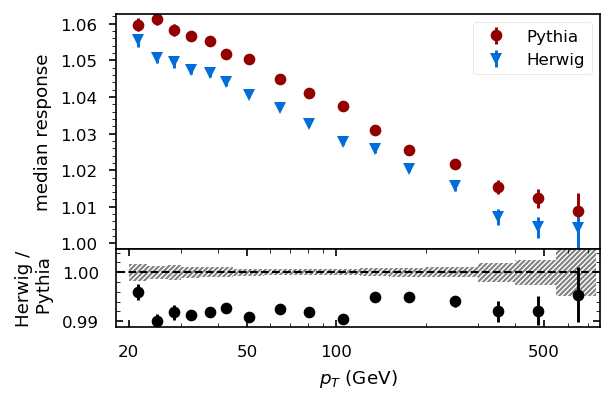

Fitting subsample:  _ud
Eta:  2
[  21.5   25.    28.5   32.5   37.5   42.5   51.    64.5   81.   105.
  135.   175.   250.   350.   475.   650.   875.  1250.  1750.  2250.
 2750.  3250.  3750.  4250.  4750.  7500. ]
[1.03117704 1.03840909 1.04373342 1.04971955 1.05787418 1.05367063
 1.04684297 1.04345466 1.03591255 1.03026938 1.02157325 1.01978777
 1.01111338 1.00716912        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan]
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_ud_eta25to30_L5_Pythia-Herwig-median


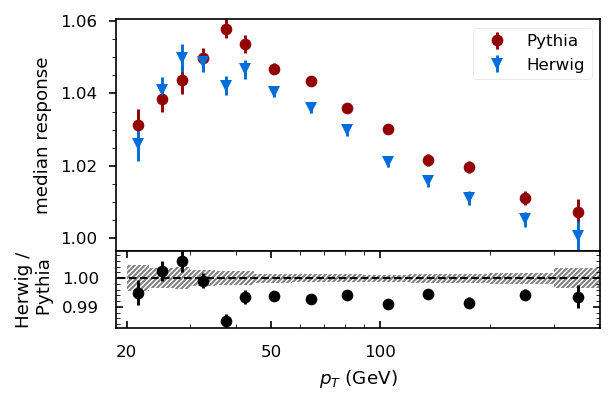

Fitting subsample:  _ud
Eta:  3
[  21.5   25.    28.5   32.5   37.5   42.5   51.    64.5   81.   105.
  135.   175.   250.   350.   475.   650.   875.  1250.  1750.  2250.
 2750.  3250.  3750.  4250.  4750.  7500. ]
[1.01969579 1.02405973 1.02432229 1.02915121 1.03126774 1.02991892
 1.02675603 1.02654867 1.01976048 1.01871166 1.01705231 1.01023077
 1.0072619         nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan]
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_ud_eta30to50_L5_Pythia-Herwig-median


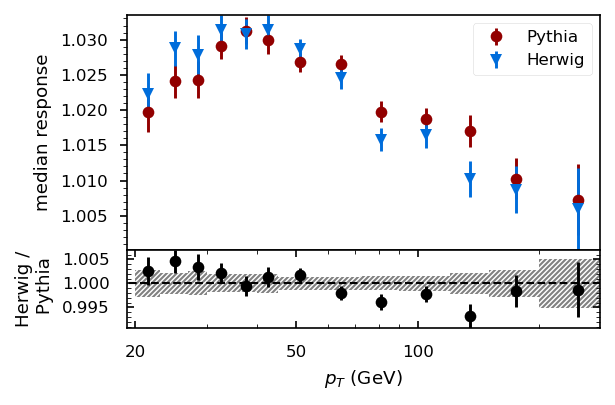

Fitting subsample:  _g
Eta:  0
[  21.5   25.    28.5   32.5   37.5   42.5   51.    64.5   81.   105.
  135.   175.   250.   350.   475.   650.   875.  1250.  1750.  2250.
 2750.  3250.  3750.  4250.  4750.  7500. ]
[0.99302326 0.98788564 0.98756131 0.98480299 0.98665372 0.98626746
 0.98705449 0.9873062  0.98821714 0.9906912  0.99066318 0.98933079
 0.99059215 0.98782316 0.98968105 0.98584906        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan]
Saving plot for eta =  _eta00to13
Saving plot with the name =  fig/corr_vs_pt_g_eta00to13_L5_Pythia-Herwig-median


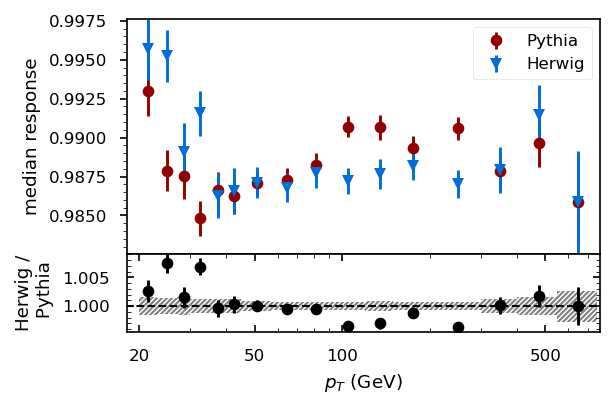

Fitting subsample:  _g
Eta:  1
[  21.5   25.    28.5   32.5   37.5   42.5   51.    64.5   81.   105.
  135.   175.   250.   350.   475.   650.   875.  1250.  1750.  2250.
 2750.  3250.  3750.  4250.  4750.  7500. ]
[0.98592851 0.98547949 0.98352904 0.98155091 0.98559815 0.98161274
 0.98173077 0.98051144 0.98006385 0.98028021 0.98069876 0.98003333
 0.97761468 0.97804054 0.97314815        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan]
Saving plot for eta =  _eta13to25
Saving plot with the name =  fig/corr_vs_pt_g_eta13to25_L5_Pythia-Herwig-median


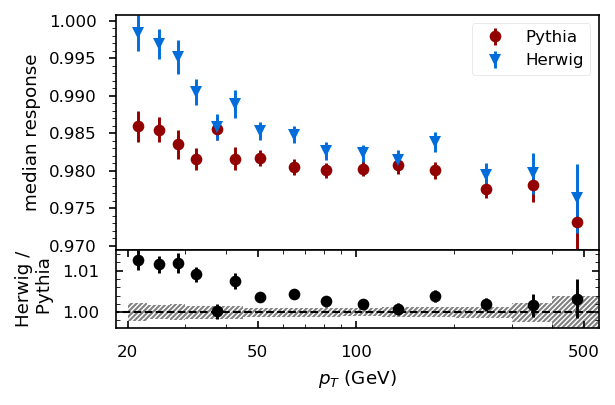

Fitting subsample:  _g
Eta:  2
[  21.5   25.    28.5   32.5   37.5   42.5   51.    64.5   81.   105.
  135.   175.   250.   350.   475.   650.   875.  1250.  1750.  2250.
 2750.  3250.  3750.  4250.  4750.  7500. ]
[0.9298913  0.94313668 0.94515125 0.95853216 0.96400227 0.96629956
 0.96651989 0.96913527 0.96878765 0.9668838  0.9702934  0.96993728
 0.96610738        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan]
Saving plot for eta =  _eta25to30
Saving plot with the name =  fig/corr_vs_pt_g_eta25to30_L5_Pythia-Herwig-median


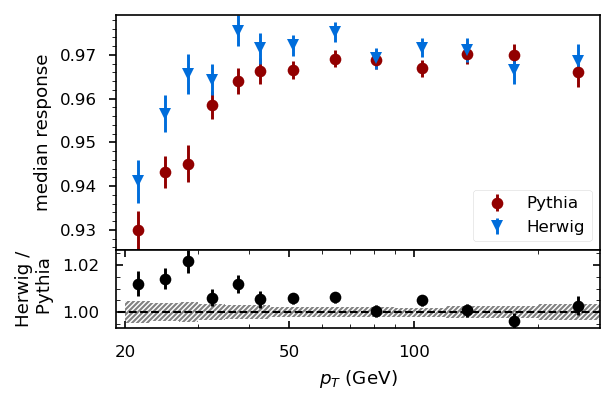

Fitting subsample:  _g
Eta:  3
[  21.5   25.    28.5   32.5   37.5   42.5   51.    64.5   81.   105.
  135.   175.   250.   350.   475.   650.   875.  1250.  1750.  2250.
 2750.  3250.  3750.  4250.  4750.  7500. ]
[0.95298246 0.96186919 0.96558045 0.96925766 0.969967   0.9702
 0.97138537 0.96567294 0.96485955 0.96182024 0.95815217 0.96083333
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan]
Saving plot for eta =  _eta30to50
Saving plot with the name =  fig/corr_vs_pt_g_eta30to50_L5_Pythia-Herwig-median


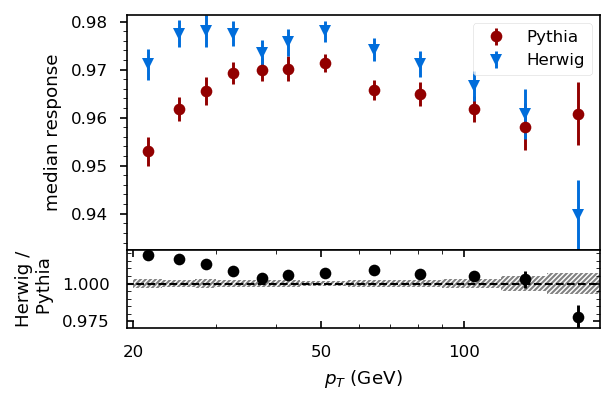

In [71]:
# load_fit_res=True
subsamples = ['', '_b', '_c', '_s', '_ud', '_g']

k2 = np.where(etabins_mod<=0)[0][-1]
k4 = np.where(etabins_mod<=1.3)[0][-1]
k6 = np.where(etabins_mod<=2.5)[0][-1]
k8 = np.where(etabins_mod<=3.0)[0][-1]
ks = [k2, k4, k6, k8]

# ks = [k2, k4] #, k6, k8]
# subsamples = [''] #, '_b']
for samp in subsamples:
    for k in ks:
        print('Fitting subsample: ', samp)
        print('Eta: ', k)
        median_QCD = read_data("Median", samp, '_L5_LHEflav_TTBAR-JME')
        medianstd_QCD = read_data("MedianStd", samp, '_L5_LHEflav_TTBAR-JME')
        median_TTBAR = read_data("Median", samp, '_L5_LHEflav_Herwig-TTBAR-JME')
        medianstd_TTBAR = read_data("MedianStd", samp, '_L5_LHEflav_Herwig-TTBAR-JME')
        
        
        make_comparison_plot(median_QCD, medianstd_QCD, median_TTBAR, medianstd_TTBAR,
                             k, samp, 'Pythia', 'Herwig')
        
3;

In [ ]:
out_txt/EtaBinsvsPtBinsMedian_b_L5_fine_etaBins_QCD.csv
out_txt/EtaBinsvsPtBinsMedian_b_L5_fine_etaBins_L5_QCD.csv


Fitting subsample:  


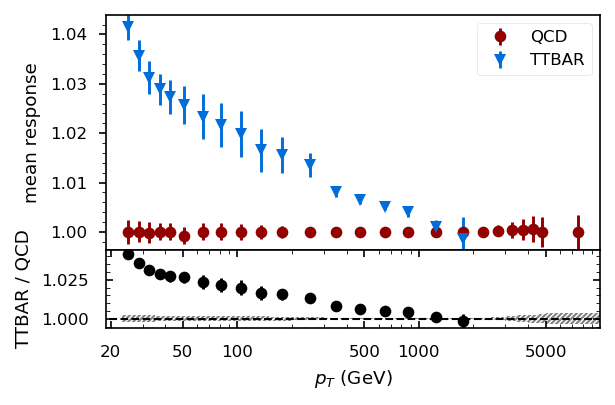

Fitting subsample:  


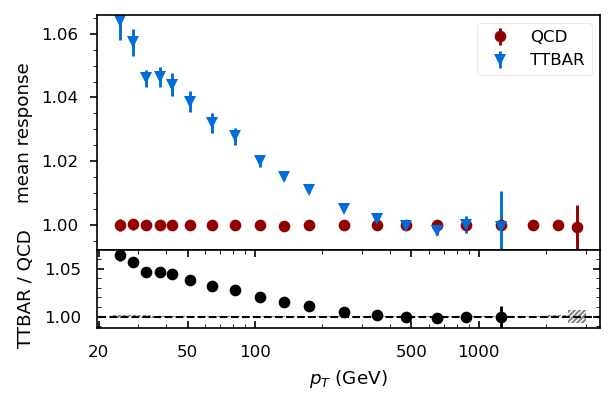

In [463]:
# load_fit_res=True
subsamples = ['', '_b', '_c', '_l', '_g']

k2 = np.where(etabins_mod<=0)[0][-1]
k4 = np.where(etabins_mod<=1.3)[0][-1]
k6 = np.where(etabins_mod<=2.5)[0][-1]
k8 = np.where(etabins_mod<=3.0)[0][-1]
ks = [k2, k4, k6, k8]

ks = [k2, k4] #, k6, k8]
subsamples = [''] #, '_b']
for samp in subsamples:
    for k in ks:
        print('Fitting subsample: ', samp)
        mean_QCD = read_data("Mean", samp, '_L5_QCD')
        meanvar_QCD = read_data("MeanVar", samp, '_L5_QCD')
        mean_TTBAR = read_data("Mean", samp, '_L5_TTBAR')
        meanvar_TTBAR = read_data("MeanVar", samp, '_L5_TTBAR')
        
        
        make_comparison_plot(mean_QCD, np.sqrt(np.abs(meanvar_QCD)), mean_TTBAR, np.sqrt(np.abs(meanvar_TTBAR)),
                             k, samp, 'QCD', 'TTBAR')
        
3;

In [ ]:
# load_fit_res=True
subsamples = ['', '_b', '_c', '_l', '_g']

k2 = np.where(etabins_mod<=0)[0][-1]
k4 = np.where(etabins_mod<=1.3)[0][-1]
k6 = np.where(etabins_mod<=2.5)[0][-1]
k8 = np.where(etabins_mod<=3.0)[0][-1]
ks = [k2, k4, k6, k8]

ks = [k2, k4] #, k6, k8]
subsamples = [''] #, '_b']
for samp in subsamples:
    for k in ks:
        print('Fitting subsample: ', samp)
        mean_QCD = read_data("Mean", samp, '_L5_QCD')
        meanvar_QCD = read_data("MeanVar", samp, '_L5_QCD')
        mean_TTBAR = read_data("Mean", samp, '_L5_TTBAR')
        meanvar_TTBAR = read_data("MeanVar", samp, '_L5_TTBAR')

        mean_p_QCD = mean_QCD.copy()
        mean_p_QCD[mean_p_QCD==0] = np.nan

        mean_p_TTBAR = mean_TTBAR.copy()
        mean_p_TTBAR[mean_p_TTBAR==0] = np.nan

        gs = fig.add_gridspec(nrows=2, ncols=1, hspace=0, height_ratios=[3, 1])
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1])
        start = 17



        p1 = plt.errorbar(ptbins[start:-1],mean_p_QCD[start:,k], yerr=np.sqrt(meanvar_QCD[start:,k]), marker='o',
                     markerfacecolor='none', markeredgewidth=1,
                     linestyle="none", label=f'${etabins_mod[k]}<\eta<{etabins_mod[k+1]}$')

        p5 = plt.errorbar(ptbins[start:-1],mean_p_TTBAR[start:,k], yerr=np.sqrt(meanvar_TTBAR[start:,k]), marker='v',
                     markerfacecolor='none', markeredgewidth=1, color=p1.lines[0].get_color(),
                     linestyle="none")

        ax3 = ax.twinx()
        ax3.plot(np.nan, marker='o',color='k',markerfacecolor='none', markeredgewidth=1, linestyle="none", label='QCD')
        ax3.plot(np.nan, marker='v',color='k',markerfacecolor='none', markeredgewidth=1, linestyle="none", label='TTBAR')

        ### Calculate resonable limits excluding the few points with insane errors
        yerr_norm = np.concatenate([np.sqrt(meanvar[start:,[k2, k4, k6, k8]]) ])
        y_norm = np.concatenate([mean_p_TTBAR[start:,[k2, k4, k6, k8]]])
        norm_pos = (yerr_norm<0.02) &  (yerr_norm != np.inf) & (y_norm>-0.1)
        ax.set_ylim(np.min((y_norm-yerr_norm)[norm_pos]) ,np.max((yerr_norm+y_norm)[norm_pos]))


        ax.set_xlabel(r'$p_T$ (GeV)');
        ax.set_ylabel(r'mean response');
        ax.set_xscale('log')
        ax.set_xticks([20, 50,100, 500, 1000, 5000])
        ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
        leg1 = ax.legend()
        leg1 = ax3.legend(loc='upper left')
        eta_string = '_eta'+str(etabins_mod[k])+'to'+str(etabins_mod[k+1])
        eta_string = eta_string.replace('.','')
        
        plt.savefig('fig/corr_vs_pt'+samp+eta_string+'_L5_QCD_TTBAR.pdf');
        plt.savefig('fig/corr_vs_pt'+samp+eta_string+'_L5_QCD_TTBAR.png');
        # gs1.tight_layout(fig, rect=[0, 0.1, 0.8, 0.5])
        plt.show();
3;

### QCD vs TTbar comparisson

Fitting subsample:  


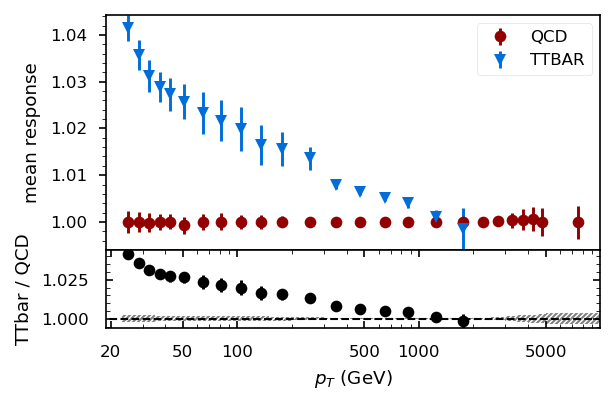

Fitting subsample:  


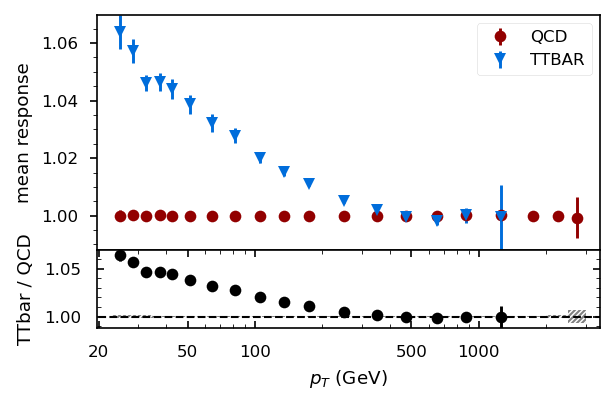

Fitting subsample:  


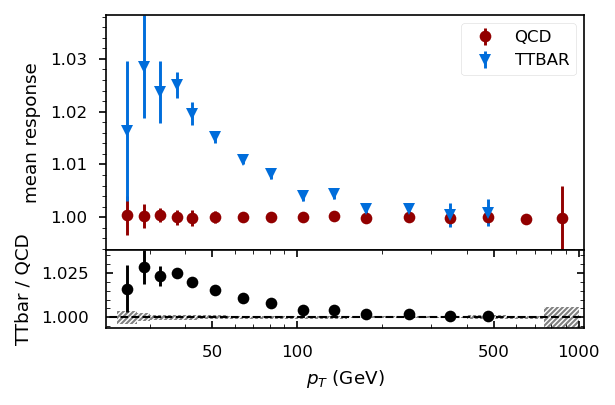

Fitting subsample:  


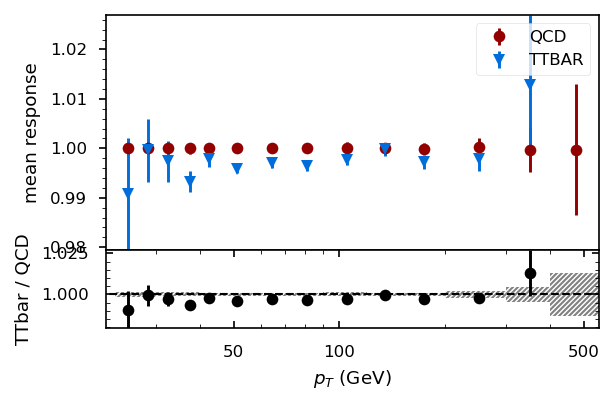

Fitting subsample:  _b


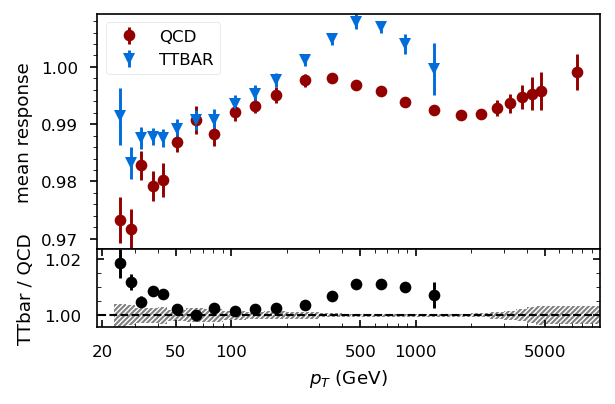

Fitting subsample:  _b


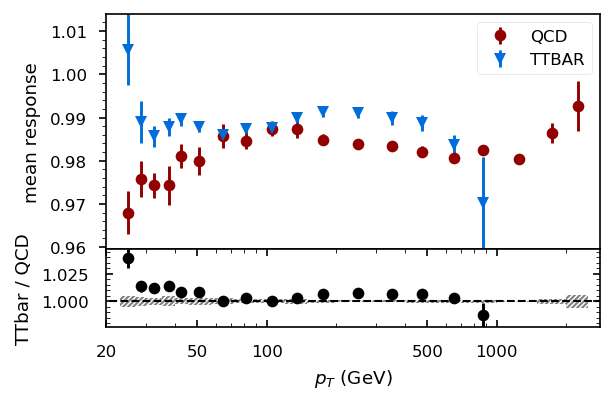

Fitting subsample:  _b


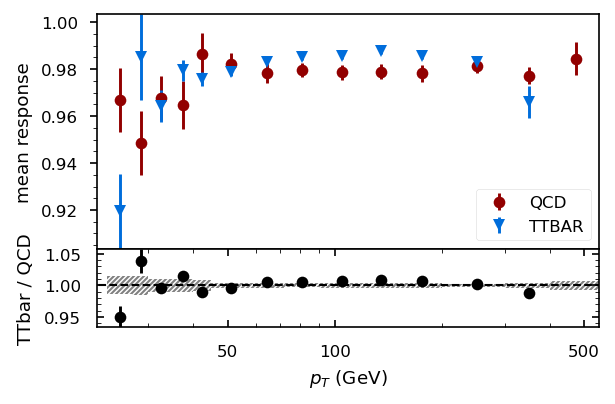

Fitting subsample:  _b


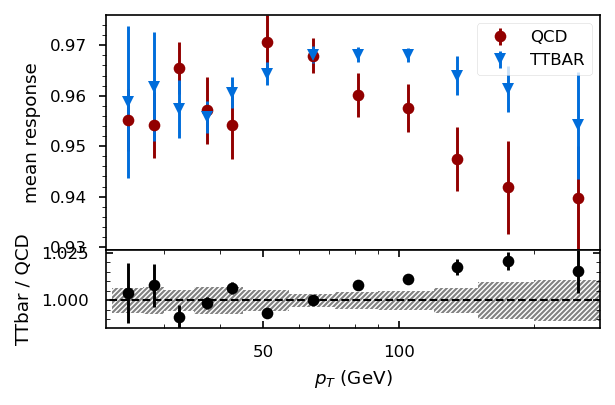

Fitting subsample:  _c


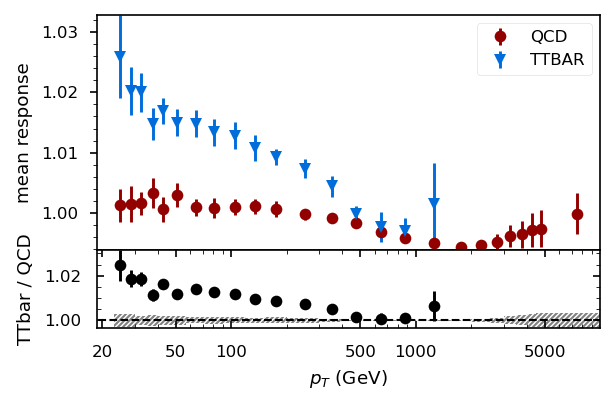

Fitting subsample:  _c


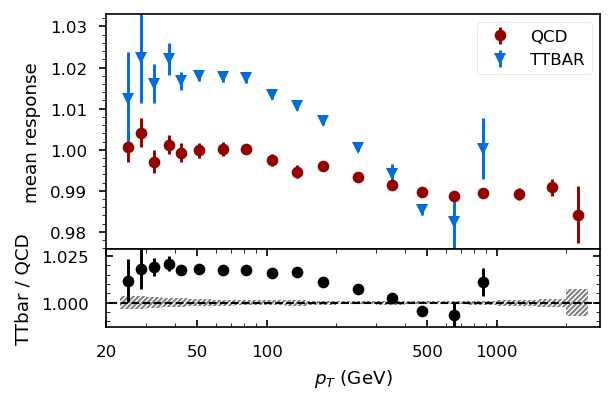

Fitting subsample:  _c


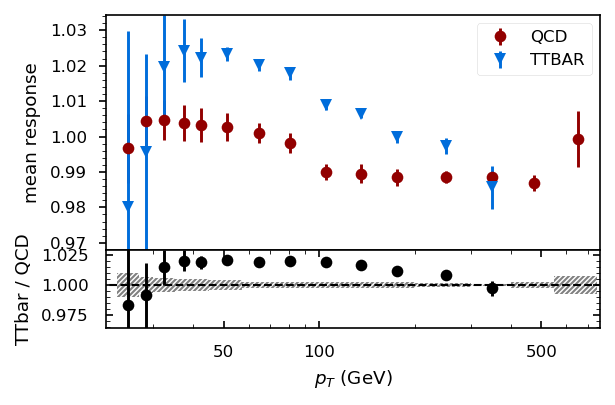

Fitting subsample:  _c


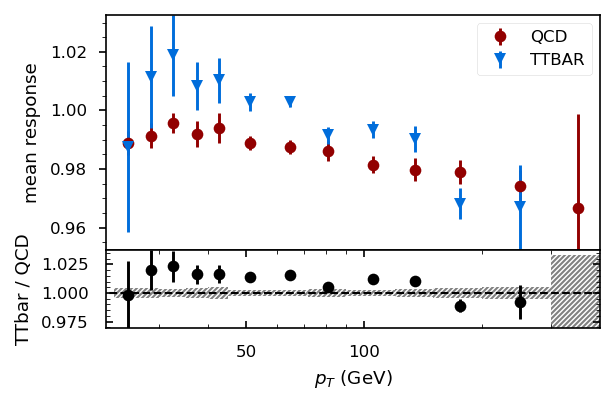

Fitting subsample:  _l


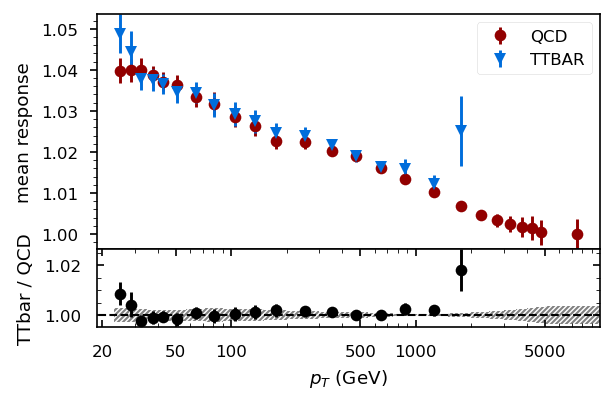

Fitting subsample:  _l


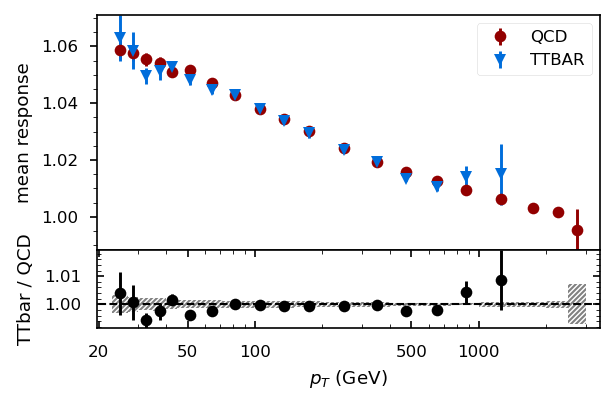

Fitting subsample:  _l


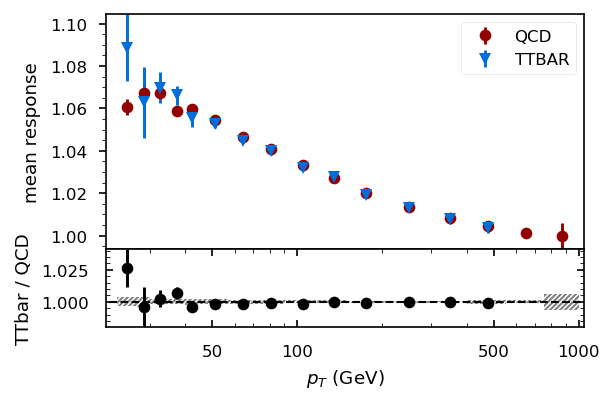

Fitting subsample:  _l


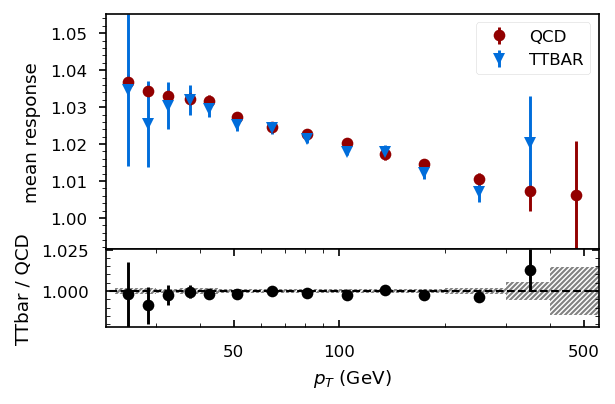

Fitting subsample:  _g


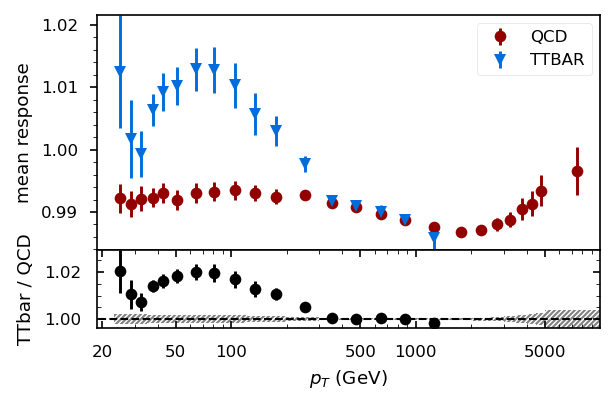

Fitting subsample:  _g


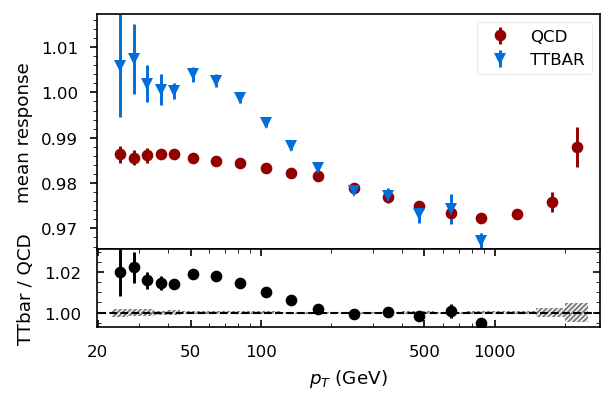

Fitting subsample:  _g


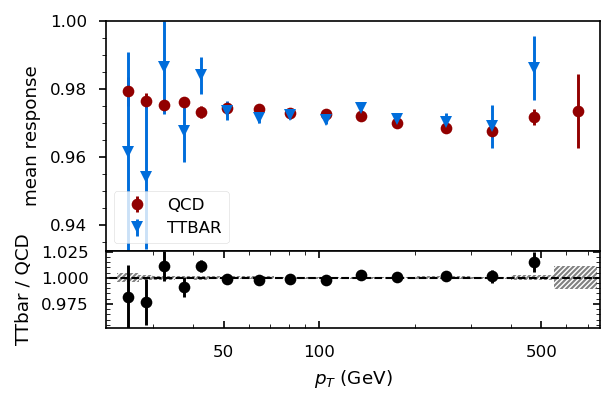

Fitting subsample:  _g


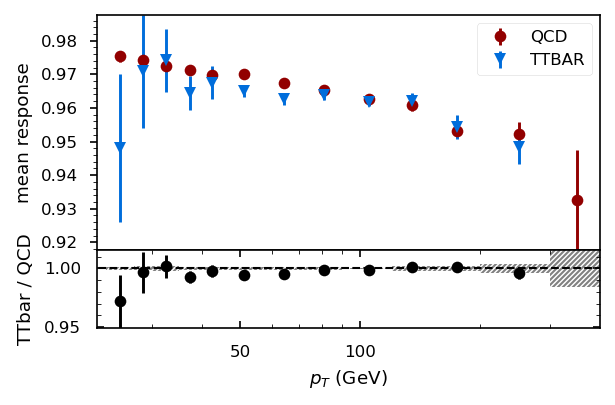

In [86]:
# load_fit_res=True
subsamples = ['', '_b', '_c', '_l', '_g']

k2 = np.where(etabins_mod<=0)[0][-1]
k4 = np.where(etabins_mod<=1.3)[0][-1]
k6 = np.where(etabins_mod<=2.5)[0][-1]
k8 = np.where(etabins_mod<=3.0)[0][-1]
ks = [k2, k4, k6, k8]

# ks = [k2, k4] #, k6, k8]
# subsamples = ['_b'] #, '_b']
for samp in subsamples:
    for k in ks:
#     print('-'*25)
#     print('-'*25)
        print('Fitting subsample: ', samp)
        mean_QCD = read_data("Mean", samp, '_L5_QCD')
        meanvar_QCD = read_data("MeanVar", samp, '_L5_QCD')
        mean_TTBAR = read_data("Mean", samp, '_L5_TTBAR')
        meanvar_TTBAR = read_data("MeanVar", samp, '_L5_TTBAR')
        
        
        mean_p_QCD = mean_QCD.copy()
        mean_p_QCD[mean_p_QCD==0] = np.nan

        mean_p_TTBAR = mean_TTBAR.copy()
        mean_p_TTBAR[mean_p_TTBAR==0] = np.nan

        fig = plt.figure()
        gs = fig.add_gridspec(nrows=2, ncols=1, hspace=0, height_ratios=[3, 1])
        ax = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1])
#         fig, [ax,ax2] = plt.subplots(nrows=2, ncols=1)
        start = 17
    
#         for item in (
#             [ax1.yaxis.label, ax2.xaxis.label, ax2.yaxis.label]
#             + ax1.get_yticklabels()
#             + ax2.get_xticklabels()
#             + ax2.get_yticklabels()
#         ):
#             item.set_fontsize("large")
    
        for axis in [ax.xaxis, ax.yaxis, ax2.xaxis, ax2.yaxis]:
            axis.set_minor_locator(mpl.ticker.AutoMinorLocator())

        xvals = (ptbins[start:-1] + ptbins[start+1:])/2
        wd = np.abs(ptbins[start:-1] - ptbins[start+1:])
        QCD_vals = mean_p_QCD[start:,k]
        TTbar_vals = mean_p_TTBAR[start:,k]

        p1 = ax.errorbar(xvals, QCD_vals, yerr=np.sqrt(meanvar_QCD[start:,k]), marker='o',
#                      markerfacecolor='none', markeredgewidth=1,
                     linestyle="none", label='QCD')

        p5 = ax.errorbar(xvals, TTbar_vals, yerr=np.sqrt(meanvar_TTBAR[start:,k]), marker='v',
#                      markerfacecolor='none', markeredgewidth=1, color=p1.lines[0].get_color(),
                     linestyle="none", label='TTBAR')
        
        ax2.hlines(1,1, 10000, linestyles='--',color="black",
            linewidth=1,)
        # ratio plot
#         ax2.plot(
#             [ptbins[0], ptbins[-1]],
#             [1, 1],
#             "--",
#             color="black",
#             linewidth=1,
#         )  # reference line along y=1
        
#         nonzero_model_yield = mean_p_QCD[start:,k] != 0.0
        rel_mc_unc =  np.sqrt(meanvar_QCD[start:,k])/QCD_vals 
        
        ax2.bar(
            xvals,
            2 * rel_mc_unc,
            width=wd,
            bottom=1.0 - rel_mc_unc,
            fill=False,
            linewidth=0,
            edgecolor="gray",
            hatch=10 * "/",
        )
        
        
#         ax3 = ax.twinx()
#         ax3.plot(np.nan, marker='o',color='k',markerfacecolor='none', markeredgewidth=1, linestyle="none", label='QCD')
#         ax3.plot(np.nan, marker='v',color='k',markerfacecolor='none', markeredgewidth=1, linestyle="none", label='TTBAR')

        # data in ratio plot
        data_model_ratio = TTbar_vals/QCD_vals
        data_model_ratio_unc = np.sqrt(meanvar_TTBAR[start:,k]) / QCD_vals
        # mask data in bins where total model yield is 0
        ax2.errorbar(
            xvals,
            data_model_ratio, #[nonzero_model_yield],
            yerr=data_model_ratio_unc, #[nonzero_model_yield],
            fmt="o",
            color="k",
        )
        
#             # figure label (region name)
#         label = 'Blaaaaah'
#         at = mpl.offsetbox.AnchoredText(
#             label,
#             loc="upper left",
#             frameon=False,
#             prop={"fontsize": "large", "linespacing": 1.5},
#         )
#         ax.add_artist(at)
        
#         ax.set_xlim(ptbins[start],ptbins[-1])

        
        ax2.set_ylabel("TTbar / QCD")
        ax2.tick_params(axis="both", which="major", pad=8)
        ax2.tick_params(direction="in", top=True, right=True, which="both")

        fig.set_tight_layout(True)

        ### Calculate resonable limits excluding the few points with insane errors
        yerr_norm = np.concatenate([np.sqrt(meanvar_QCD[start:,k]), np.sqrt(meanvar_TTBAR[start:,k]) ])
        y_norm = np.concatenate([QCD_vals, TTbar_vals])
        norm_pos = (yerr_norm<0.03) &  (yerr_norm != np.inf) & (y_norm>-0.1)
        ax.set_ylim(np.min((y_norm-yerr_norm)[norm_pos]), np.max((yerr_norm+y_norm)[norm_pos]))
        
        yerr_norm = np.concatenate([np.sqrt(meanvar_QCD[start:,k])/QCD_vals, np.sqrt(meanvar_TTBAR[start:,k])/QCD_vals ])
        y_norm = np.concatenate([QCD_vals/QCD_vals, TTbar_vals/QCD_vals])
        norm_pos = (yerr_norm<0.03) &  (yerr_norm != np.inf) & (y_norm>-0.1) 
        ax2.set_ylim(np.min((y_norm-yerr_norm)[norm_pos]), np.max((yerr_norm+y_norm)[norm_pos]))

        ax2.set_xlabel(r'$p_T$ (GeV)');
#         ax.set_xlabel(r'$p_T$ (GeV)');
        ax.set_ylabel(r'mean response');
        ax.set_xscale('log')
        ax2.set_xscale('log')
        
        ax.set_xticks([])
        ax2.set_xticks([20, 50,100, 500, 1000, 5000])
#         ax.get_xaxis().get_major_formatter().labelOnlyBase = False
        ax2.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
        leg1 = ax.legend()
#         leg1 = ax3.legend(loc='upper left')
        # fig.legend((p1, p5), ('QCD', 'TTBAR'), loc='upper right')  #,bbox_to_anchor=(0.5, 0., 0.47, 0.98)) #loc="upper right")
        # if test_run:
        #     plt.savefig('test/fig/corr_vs_pt'+samp+tag_full+'_test.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
        #     plt.savefig('test/fig/corr_vs_pt'+samp+tag_full+'_test.png', dpi=plt.rcParamsDefault['figure.dpi']);
        # else:
#         print("x lim = ", ax.get_xlim())
        ax2.set_xlim(ax.get_xlim())
        eta_string = '_eta'+str(etabins_mod[k])+'to'+str(etabins_mod[k+1])
        eta_string = eta_string.replace('.','')
        
        plt.savefig('fig/corr_vs_pt'+samp+eta_string+'_L5_QCD_TTBAR.pdf');
        plt.savefig('fig/corr_vs_pt'+samp+eta_string+'_L5_QCD_TTBAR.png');
        # gs1.tight_layout(fig, rect=[0, 0.1, 0.8, 0.5])
        plt.show();
3;

### Herwig vs Pythia comparisson

Fitting subsample:  


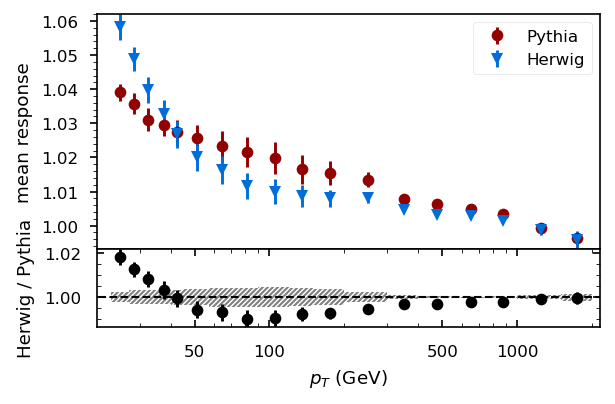

Fitting subsample:  


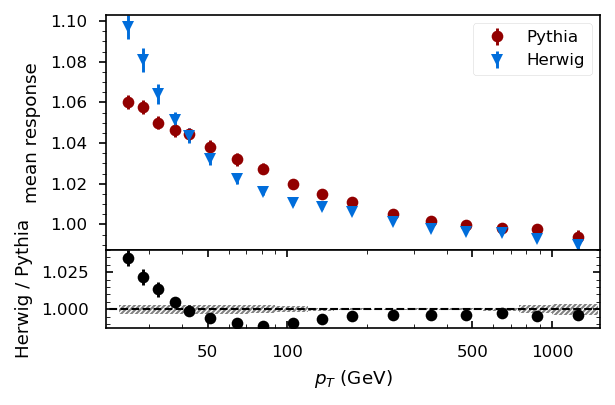

Fitting subsample:  


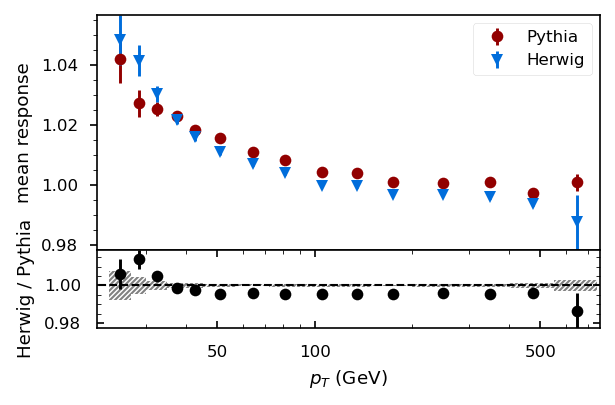

Fitting subsample:  


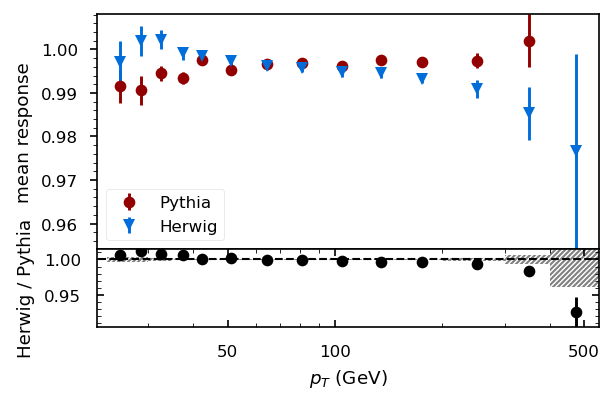

Fitting subsample:  _b


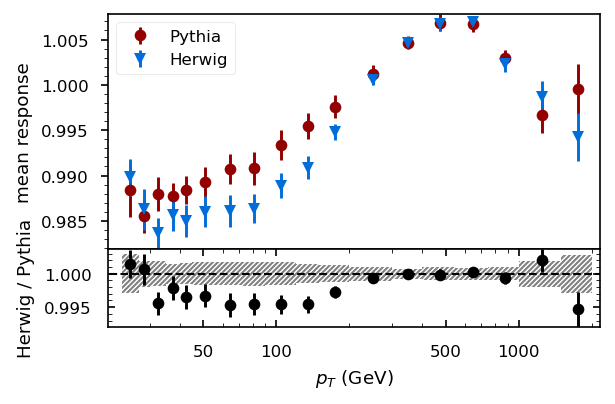

Fitting subsample:  _b


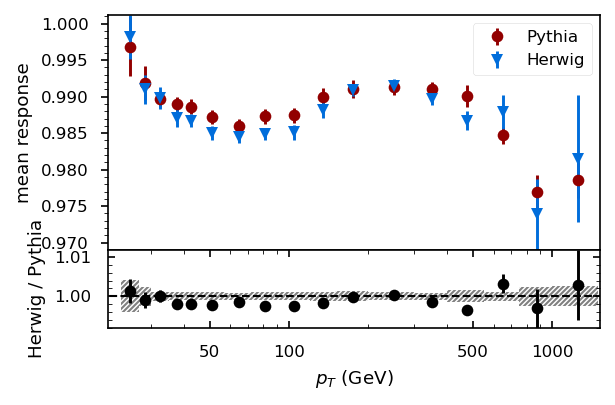

Fitting subsample:  _b


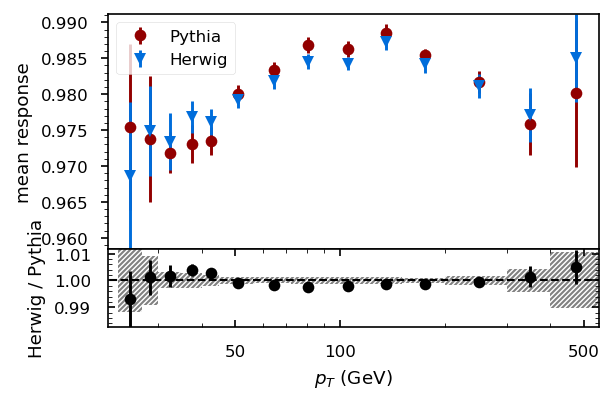

Fitting subsample:  _b


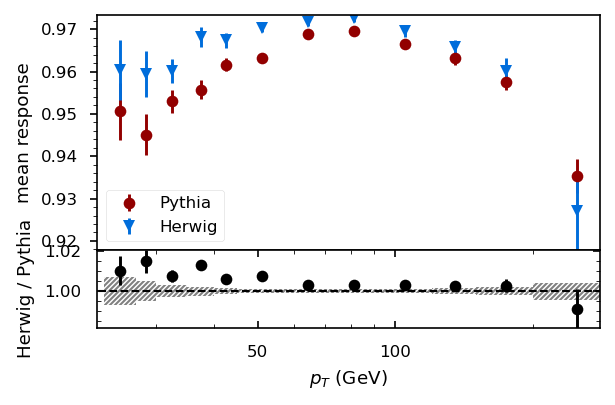

Fitting subsample:  _c


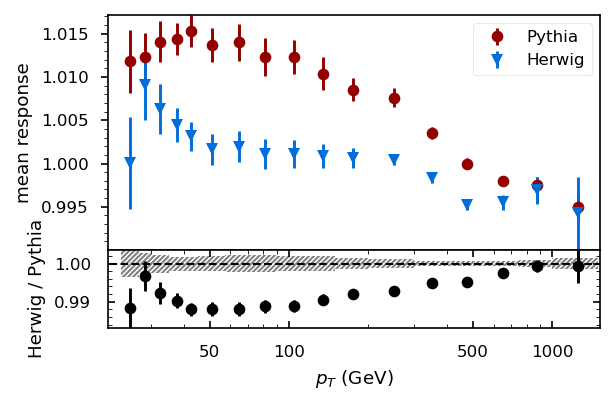

Fitting subsample:  _c


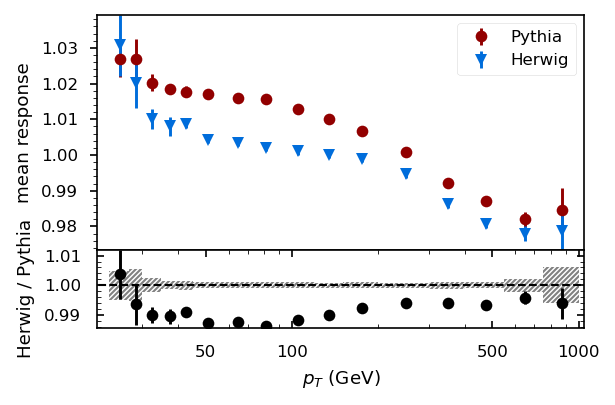

Fitting subsample:  _c


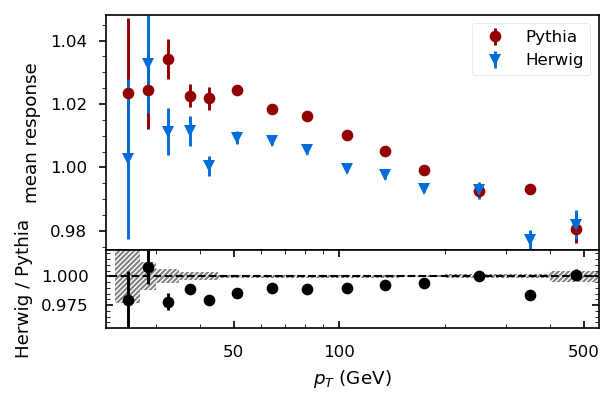

Fitting subsample:  _c


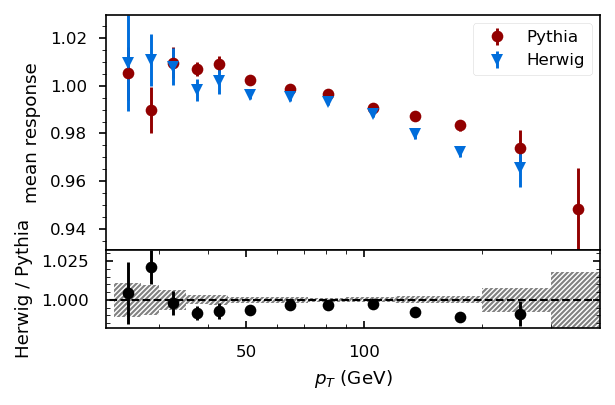

In [87]:
# load_fit_res=True
subsamples = ['', '_b', '_c']

k2 = np.where(etabins_mod<=0)[0][-1]
k4 = np.where(etabins_mod<=1.3)[0][-1]
k6 = np.where(etabins_mod<=2.5)[0][-1]
k8 = np.where(etabins_mod<=3.0)[0][-1]
ks = [k2, k4, k6, k8]

ks = [k2, k4, k6, k8] #, k6, k8]
# subsamples = ['_b'] #, '_b']
for samp in subsamples:
    for k in ks:
        print('Fitting subsample: ', samp)
        mean_TTBAR = read_data("Mean", samp, '_L5_TTBAR-hadflav-0-50')
        meanvar_TTBAR = read_data("MeanVar", samp, '_L5_TTBAR-hadflav-0-50')
        mean_Herwig = read_data("Mean", samp, '_L5_Herwig-TTBAR')
        meanvar_Herwig = read_data("MeanVar", samp, '_L5_Herwig-TTBAR')

        mean_p_Herwig = mean_Herwig.copy()
        mean_p_Herwig[mean_p_Herwig==0] = np.nan

        mean_p_TTBAR = mean_TTBAR.copy()
        mean_p_TTBAR[mean_p_TTBAR==0] = np.nan

        fig = plt.figure()
        gs = fig.add_gridspec(nrows=2, ncols=1, hspace=0, height_ratios=[3, 1])
        ax = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1])
#         fig, [ax,ax2] = plt.subplots(nrows=2, ncols=1)
        start = 17
    

        for axis in [ax.xaxis, ax.yaxis, ax2.xaxis, ax2.yaxis]:
            axis.set_minor_locator(mpl.ticker.AutoMinorLocator())

        xvals = (ptbins[start:-1] + ptbins[start+1:])/2
        wd = np.abs(ptbins[start:-1] - ptbins[start+1:])
        Herwig_vals = mean_p_Herwig[start:,k]
        TTbar_vals = mean_p_TTBAR[start:,k]

        p5 = ax.errorbar(xvals, TTbar_vals, yerr=np.sqrt(meanvar_TTBAR[start:,k]), marker='o',
#                      markerfacecolor='none', markeredgewidth=1, color=p1.lines[0].get_color(),
                     linestyle="none", label='Pythia')
      
        p1 = ax.errorbar(xvals, Herwig_vals, yerr=np.sqrt(meanvar_Herwig[start:,k]), marker='v',
#                      markerfacecolor='none', markeredgewidth=1,
                     linestyle="none", label='Herwig')

   
        ax2.hlines(1,1, 10000, linestyles='--',color="black",
            linewidth=1,)
        rel_mc_unc =  np.sqrt(meanvar_TTBAR[start:,k])/TTbar_vals 
        
        ax2.bar(
            xvals,
            2 * rel_mc_unc,
            width=wd,
            bottom=1.0 - rel_mc_unc,
            fill=False,
            linewidth=0,
            edgecolor="gray",
            hatch=10 * "/",
        )
        
        data_model_ratio = Herwig_vals/TTbar_vals
        data_model_ratio_unc = np.sqrt(meanvar_Herwig[start:,k]) / TTbar_vals
        # mask data in bins where total model yield is 0
        ax2.errorbar(
            xvals,
            data_model_ratio, #[nonzero_model_yield],
            yerr=data_model_ratio_unc, #[nonzero_model_yield],
            fmt="o",
            color="k",
        )
        
        
        ax2.set_ylabel("Herwig / Pythia")
        ax2.tick_params(axis="both", which="major", pad=8)
        ax2.tick_params(direction="in", top=True, right=True, which="both")

        fig.set_tight_layout(True)

        ### Calculate resonable limits excluding the few points with insane errors
        yerr_norm = np.concatenate([np.sqrt(meanvar_Herwig[start:,k]), np.sqrt(meanvar_TTBAR[start:,k]) ])
        y_norm = np.concatenate([Herwig_vals, TTbar_vals])
        norm_pos = (yerr_norm<0.03) &  (yerr_norm != np.inf) & (y_norm>-0.1)
        ax.set_ylim(np.min((y_norm-yerr_norm)[norm_pos]), np.max((yerr_norm+y_norm)[norm_pos]))
        
        yerr_norm = np.concatenate([np.sqrt(meanvar_Herwig[start:,k])/TTbar_vals, np.sqrt(meanvar_TTBAR[start:,k])/TTbar_vals ])
        y_norm = np.concatenate([Herwig_vals/TTbar_vals, TTbar_vals/TTbar_vals])
        norm_pos = (yerr_norm<0.03) &  (yerr_norm != np.inf) & (y_norm>-0.1) 
        ax2.set_ylim(np.min((y_norm-yerr_norm)[norm_pos]), np.max((yerr_norm+y_norm)[norm_pos]))

        ax2.set_xlabel(r'$p_T$ (GeV)');
#         ax.set_xlabel(r'$p_T$ (GeV)');
        ax.set_ylabel(r'mean response');
        ax.set_xscale('log')
        ax2.set_xscale('log')
        
        ax.set_xticks([])
        ax2.set_xticks([20, 50,100, 500, 1000, 5000])
#         ax.get_xaxis().get_major_formatter().labelOnlyBase = False
        ax2.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
        leg1 = ax.legend()
#         leg1 = ax3.legend(loc='upper left')

        ax2.set_xlim(ax.get_xlim())
        eta_string = '_eta'+str(etabins_mod[k])+'to'+str(etabins_mod[k+1])
        eta_string = eta_string.replace('.','')
        
        plt.savefig('fig/corr_vs_pt'+samp+eta_string+'_L5_Herwig_Pythia-hadflav.pdf');
        plt.savefig('fig/corr_vs_pt'+samp+eta_string+'_L5_Herwig_Pythia-hadflav.png');
        # gs1.tight_layout(fig, rect=[0, 0.1, 0.8, 0.5])
        plt.show();
3;

In [280]:
yerr_norm = np.concatenate([np.sqrt(meanvar_QCD[start:,k]), np.sqrt(meanvar_TTBAR[start:,k]) ])
y_norm = np.concatenate([QCD_vals, TTbar_vals])
norm_pos = (yerr_norm<0.02) &  (yerr_norm != np.inf) & (y_norm>-0.1)

In [ ]:
def plot_corrections(mean, samp, meanvar):
    ### To ignore the points with 0 on y axis when setting the y axis limits
    mean_p = mean.copy()
    mean_p[mean_p==0] = np.nan

    # h = np.max(histo.values()[('QCD',)])
    fig, ax = plt.subplots()
    start = 17
    
#     etabins_mod = np.flip(etabins[(len(etabins)-1)//2:])
    
#     k1 = np.where(etabins<=-1.3)[0][-1]
    k2 = np.where(etabins_mod<=0)[0][-1]
#     k3 = np.where(etabins<=-2.5)[0][-1]
    k4 = np.where(etabins_mod<=1.3)[0][-1]
#     k5 = np.where(etabins<=-3)[0][-1]
    k6 = np.where(etabins_mod<=2.5)[0][-1]
#     k7 = np.where(etabins<=-5)[0][-1]
    k8 = np.where(etabins_mod<=3.0)[0][-1]
    

    plt.errorbar(ptbins[start:-1],mean_p[start:,k2], yerr=np.sqrt(meanvar[start:,k2]), marker='o',
                 linestyle="none", label=f'${etabins_mod[k2]}<\eta<{etabins_mod[k2+1]}$')
    plt.errorbar(ptbins[start:-1],mean_p[start:,k4], yerr=np.sqrt(meanvar[start:,k4]), marker='o',
             linestyle="none", label=f'${etabins_mod[k4]}<\eta<{etabins_mod[k4+1]}$')
    plt.errorbar(ptbins[start:-1],mean_p[start:,k6], yerr=np.sqrt(meanvar[start:,k6]), marker='o',
             linestyle="none", label=f'${etabins_mod[k6]}<\eta<{etabins_mod[k6+1]}$')
    plt.errorbar(ptbins[start:-1],mean_p[start:,k8], yerr=np.sqrt(meanvar[start:,k8]), marker='o',
             linestyle="none", label=f'${etabins_mod[k8]}<\eta<{etabins_mod[k8+1]}$')

    ### Calculate resonable limits excluding the few points with insane errors
    yerr_norm = np.concatenate([np.sqrt(meanvar[start:,[k2, k4, k6, k8]]) ])
    y_norm = np.concatenate([mean_p[start:,[k2, k4, k6, k8]]])
    norm_pos = (yerr_norm<0.02) &  (yerr_norm != np.inf) & (y_norm>-0.1)
    ax.set_ylim(np.min((y_norm-yerr_norm)[norm_pos]) ,np.max((yerr_norm+y_norm)[norm_pos]))

    ax.set_xlabel(r'$p_T$ (GeV)');
    ax.set_ylabel(r'mean response');
    ax.set_xscale('log')
    # ax.set_ylim([0.8,1.1])
    ax.legend()
    if test_run:
        plt.savefig('test/fig/corr_vs_pt'+samp+tag_full+'_test.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
        plt.savefig('test/fig/corr_vs_pt'+samp+tag_full+'_test.png', dpi=plt.rcParamsDefault['figure.dpi']);
    else:
        plt.savefig('fig/corr_vs_pt'+samp+tag_full+'.pdf');
        plt.savefig('fig/corr_vs_pt'+samp+tag_full+'.png');

    plt.show();
    
# plotCorrections()

In [31]:
add_tag = '_QCD' # '_testing_19UL18' # ''
tag_full = tag+add_tag

outname_QCD = 'out/CoffeaJERCOutputs_L5_QCD.coffea'
outname_TTBAR = 'out/CoffeaJERCOutputs_L5_TTBAR.coffea'


df_csv = pd.read_csv('test/out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'_test.csv').set_index('etaBins')
#         df.to_csv('out_txt/EtaBinsvsPtBins'+name+tag+'_test.csv')
    
#     df_csv = pd.read_csv('out_txt/EtaBinsvsPtBinsMean_L5.csv').set_index('etaBins')
data = df_csv.to_numpy().transpose()
    
output_QCD = util.load(outname_QCD)
output_TTBAR = util.load(outname_TTBAR)


### Fit a specific $\eta$ $p_T$ bin

In [236]:

mean = np.zeros((jetpt_length, jeteta_length))
median = np.zeros((jetpt_length, jeteta_length))
width = np.zeros((jetpt_length, jeteta_length))
chi2s = np.zeros((jetpt_length, jeteta_length))
meanvar = np.zeros((jetpt_length, jeteta_length))
#     idx = []

N_converge = 0
N_not_converge = 0

FitFigDir = 'fig/response_pt_eta'+samp+tag_full
print("Images will be saved under ", FitFigDir)
if not os.path.exists(FitFigDir):
    os.mkdir(FitFigDir)
    
edd = output['ptresponse'+samp].axis('ptresponse').edges()
plot_pt_edges = edd[0:np.nonzero(edd>=2.0)[0][0]]
# plot_pt_edges = output['ptresponse'+samp].axis('ptresponse').edges()[0:42] ##Put plotting limits to the histogram
hist_pt_edges = plot_pt_edges[1:-1]   #for plotting. To explude overflow from the plot
plot_response_axis = hist.Bin("jeteta", r"Jet $\eta$", hist_pt_edges)

xvals = output['ptresponse'+samp].axis('ptresponse').centers()[1:] #[1:] to exclude the second peak for low pt
f_xvals = np.linspace(0,5,5001)
response_edges = output['ptresponse'+samp].axis('ptresponse').edges()[1:]

Images will be saved under  fig/response_pt_eta_L5_fine_etaBins_QCD


In [237]:
# np.where(xvals>=p[1]+np.abs(p[2])*1.5)

In [238]:
samp=''

In [266]:
etabins

array([-5.191, -4.889, -4.716, -4.538, -4.363, -4.191, -4.013, -3.839,
       -3.664, -3.489, -3.314, -3.139, -2.964, -2.853, -2.65 , -2.5  ,
       -2.322, -2.172, -2.043, -1.93 , -1.83 , -1.74 , -1.653, -1.566,
       -1.479, -1.392, -1.305, -1.218, -1.131, -1.044, -0.957, -0.879,
       -0.783, -0.696, -0.609, -0.522, -0.435, -0.348, -0.261, -0.174,
       -0.087,  0.   ,  0.087,  0.174,  0.261,  0.348,  0.435,  0.522,
        0.609,  0.696,  0.783,  0.879,  0.957,  1.044,  1.131,  1.218,
        1.305,  1.392,  1.479,  1.566,  1.653,  1.74 ,  1.83 ,  1.93 ,
        2.043,  2.172,  2.322,  2.5  ,  2.65 ,  2.853,  2.964,  3.139,
        3.314,  3.489,  3.664,  3.839,  4.013,  4.191,  4.363,  4.538,
        4.716,  4.889,  5.191])

In [546]:
samp='_g'

In [549]:
ptbins

array([   15.,    17.,    20.,    23.,    27.,    30.,    35.,    40.,
          45.,    57.,    72.,    90.,   120.,   150.,   200.,   300.,
         400.,   550.,   750.,  1000.,  1500.,  2000.,  2500.,  3000.,
        3500.,  4000.,  4500.,  5000., 10000.])

In [552]:
# histoMi = output['ptresponse'+samp].integrate('jeteta', hist.Interval(4.538,  4.716)).integrate('pt', hist.Interval(15, 40))
# histoPl = output['ptresponse'+samp].integrate('jeteta', hist.Interval(-4.716, -4.538)).integrate('pt', hist.Interval(15, 40))

histoMi = output['ptresponse'+samp].integrate('jeteta', hist.Interval(0,  1.3)).integrate('pt', hist.Interval(23, 27))
histoPl = output['ptresponse'+samp].integrate('jeteta', hist.Interval(-1.3, 0)).integrate('pt', hist.Interval(23, 27))
histo = (histoMi+histoPl)
yvals = histo.values()[('QCD',)][1:]  #[1:] to exclude the second peak for low pt

N = histo.integrate('ptresponse').values()[('QCD',)]-histo.values()[('QCD',)][0]

####################### Calculate median and rms ############################
yvals_cumsum = np.cumsum(yvals)
med_bin = np.nonzero(yvals_cumsum>N/2)[0][0] if N>0 else 0
median = response_edges[med_bin] + (N/2 - yvals_cumsum[med_bin-1])/yvals[med_bin]*(response_edges[med_bin+1]
                                                                          - response_edges[med_bin])

hist_mean = np.sum(xvals*yvals)/sum(yvals) 
hist_rms = np.sqrt(np.sum(yvals*((hist_mean-xvals)**2))/sum(yvals))
medianstd = 1.253 * hist_rms/np.sqrt(N)

####################### Fitting ############################
nonzero_bins = np.sum(yvals>0)
if nonzero_bins<2 or N<50:
    p2=[0,0,0]
    chi2 = np.nan
    arr = np.array([[np.nan]*3]*3)
    Ndof = 0
#                 print("Too little data points, skipping p = ", p2)
else:
    try:
        p, arr = curve_fit(gauss, xvals, yvals, p0=[10,1,1])
        N_converge += 1
             ######## Second Gaussian ########
        xfit_l = np.where(xvals>=p[1]-np.abs(p[2])*1.5)[0][0]
        xfit_hs = np.where(xvals>=p[1]+np.abs(p[2])*1.5)[0]
        xfit_h = xfit_hs[0] if len(xfit_hs)>0 else len(xvals)
#                     print("xfit_l = ", xfit_l, ", xfit_h = ", xfit_h)

        if len(range(xfit_l,xfit_h))<6: #if there are only 3pnts, the uncertainty is infty
            xfit_l = xfit_l-1
            xfit_h = xfit_h+1
            if len(range(xfit_l,xfit_h))<6:
                xfit_l = xfit_l-1
                xfit_h = xfit_h+1
        if xfit_l<0:
            xfit_h-=xfit_l
            xfit_l = 0
        xvals2 = xvals[xfit_l: xfit_h]
        yvals2 = yvals[xfit_l: xfit_h]
#                     if ptBin.lo>290:
#                         print("xfit_l = ", xfit_l, ", h = ", xfit_h)
#                         print("yvals = ", yvals)
#                         print("yvals2 = ", yvals2)
        p2, arr = curve_fit(gauss, xvals2, yvals2, p0=p)

        ygaus = gauss(xvals, *p2)
        chi2 = sum((yvals-ygaus)**2/(yvals+1E-9))
        Ndof = len(xvals2)-3
#                     if chi2<50000:
#                         pass
#                         print("Fit converged, p = ", p2, ", chi2 = ", chi2 )
#                     else:
#                         print("Fit failed because of high chi2, p = ", p2, ", chi2 = ", chi2 )
    except(RuntimeError):
        p2=[0,0,0]
#                     print("Fit failed because of non-convergance, p = ", p2)
        chi2 = np.nan
        arr = np.array([[np.nan]*3]*3)
        Ndof = 0
        N_not_converge += 1

fgaus2 = gauss(f_xvals, *p2)
histo = histo.rebin('ptresponse', plot_response_axis)
width_ik = np.abs(p2[2])




/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Mon/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/hist_tools.py:665: RuntimeWarning: Reducing along axis <Bin (name=jeteta) instance at 0x7fabf0163f10>: requested stop 1.3 between bin boundaries, no interpolation is performed
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Mon/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/hist_tools.py:638: RuntimeWarning: Reducing along axis <Bin (name=jeteta) instance at 0x7fabf0163f10>: requested start -1.3 between bin boundaries, no interpolation is performed
  warnings.warn(


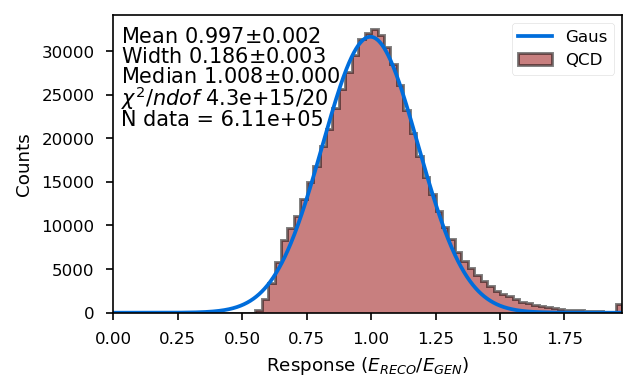

In [553]:
fig, ax2 = plt.subplots();
hist.plot1d(histo, ax=ax2, overlay='dataset', overflow='all',
            fill_opts={'alpha': .5, 'edgecolor': (0,0,0,0.3), 'linewidth': 1.4})
# ax2.plot(f_xvals, fgaus, label='Gaus',linewidth=1.8)
ax2.plot(f_xvals, fgaus2, label='Gaus',linewidth=1.8)
ax2.set_xlabel("Response ($E_{RECO}/E_{GEN}$)")
ax2.set_xlim(plot_pt_edges[[0,-1]])
h = ax2.get_ylim()[1]/1.05
plt.text(0.03,0.95*h,r'Mean {0:0.3f}$\pm${1:0.3f}'.format(p2[1], np.sqrt(arr[1,1])))
plt.text(0.03,0.88*h,r'Width {0:0.3f}$\pm${1:0.3f}'.format(width_ik, np.sqrt(arr[2,2])))
plt.text(0.03,0.81*h,r'Median {0:0.3f}$\pm${1:0.3f}'.format(median, medianstd))
plt.text(0.03,0.73*h,r'$\chi^2/ndof$ {0:0.2g}/{1:0.0f}'.format(chi2, Ndof))
plt.text(0.03,0.66*h,r'N data = {0:0.3g}'.format(N))
ax2.legend();

# plt.close();    

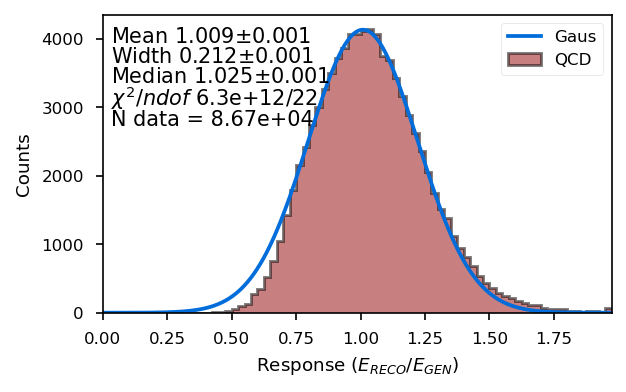

In [269]:
fig, ax2 = plt.subplots();
hist.plot1d(histo, ax=ax2, overlay='dataset', overflow='all',
            fill_opts={'alpha': .5, 'edgecolor': (0,0,0,0.3), 'linewidth': 1.4})
# ax2.plot(f_xvals, fgaus, label='Gaus',linewidth=1.8)
ax2.plot(f_xvals, fgaus2, label='Gaus',linewidth=1.8)
ax2.set_xlabel("Response ($E_{RECO}/E_{GEN}$)")
ax2.set_xlim(plot_pt_edges[[0,-1]])
h = ax2.get_ylim()[1]/1.05
plt.text(0.03,0.95*h,r'Mean {0:0.3f}$\pm${1:0.3f}'.format(p2[1], np.sqrt(arr[1,1])))
plt.text(0.03,0.88*h,r'Width {0:0.3f}$\pm${1:0.3f}'.format(width_ik, np.sqrt(arr[2,2])))
plt.text(0.03,0.81*h,r'Median {0:0.3f}$\pm${1:0.3f}'.format(median, medianstd))
plt.text(0.03,0.73*h,r'$\chi^2/ndof$ {0:0.2g}/{1:0.0f}'.format(chi2, Ndof))
plt.text(0.03,0.66*h,r'N data = {0:0.3g}'.format(N))
ax2.legend();

# plt.close();    

### Save fit data to csv's

### Read csv


 

format for example $ 20 \text{ GeV} < p_T < 25 \text{ GeV} $ and $ 3.5 < \eta < 4.0 $


```
df = pd.read_csv('EtaBinsvsPtBinsMean.csv).set_index('etaBins')
ptBin='[20, 25)'
etaBin='[3.5, 4)'
mean = df[ptBin][etaBin]
```




In [ ]:
# df_csv = pd.read_csv('out_txt/EtaBinsvsPtBinsMean_L5.csv').set_index('etaBins')

In [ ]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(df_csv)

In [ ]:
print('-----'*10)
print("All done. Congrats!")